# ⭐ Problem Statement

Every NBA season, predicting the Most Valuable Player (MVP) is challenging because voting is influenced by many factors beyond just scoring. Voters consider a player’s all-around performance, team success, advanced metrics, and even intangible qualities like consistency and impact. With so many variables interacting at once, it becomes difficult to accurately estimate who truly has the highest chance of winning MVP.
Teams, analysts, and fans often rely on subjective opinions rather than data-driven insights.

A machine learning model can transform this complexity into a structured, measurable system by learning patterns from past MVP seasons and identifying which statistical factors matter most.

**This model is trained on historical NBA seasons to identify MVP-caliber performance patterns and can be applied to future seasons to rank players by MVP likelihood based solely on their statistical profile.**

# ⭐ Project Objective

The objective of this project is to build a predictive machine learning model that estimates a player’s probability of winning the NBA MVP award using per-game stats, advanced metrics, and team performance indicators.
By training algorithms such as **Random Forest, Gradient Boosting, and XGBoost**, the model will learn how features like scoring, assists, rebounds, efficiency, team wins, and SRS historically influence MVP voting share.

The final goal is to deploy this model as an interactive **MVP Predictor App** where users can input a player’s season stats and instantly receive a predicted MVP probability.
This creates a valuable, real-world tool demonstrating how advanced machine learning can improve decision-making, storytelling, and analysis in professional sports.

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor
        )

from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV


import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("players_mvp_stats.csv")

In [3]:
df.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,29,Atlanta Hawks,PG,79,79,32.7,5.6,12.9,0.435,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,31,Atlanta Hawks,SF,81,81,38.0,9.5,20.2,0.470,...,29.0,960.0,0.03,43.0,39.0,0.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,25,Atlanta Hawks,SF,78,2,14.9,2.2,4.6,0.489,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
3,Gary Leonard,23,Atlanta Hawks,C,4,0,2.3,0.0,0.0,NaN,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
4,John Battle,28,Atlanta Hawks,SG,79,2,23.6,5.0,10.9,0.461,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72


In [4]:
df.shape

(14465, 47)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14465 entries, 0 to 14464
Data columns (total 47 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   14465 non-null  object 
 1   Age      14465 non-null  int64  
 2   Team     14465 non-null  object 
 3   Pos      14465 non-null  object 
 4   G        14465 non-null  int64  
 5   GS       14465 non-null  int64  
 6   MP       14465 non-null  float64
 7   FG       14465 non-null  float64
 8   FGA      14465 non-null  float64
 9   FG%      14397 non-null  float64
 10  3P       14465 non-null  float64
 11  3PA      14465 non-null  float64
 12  3P%      12540 non-null  float64
 13  2P       14465 non-null  float64
 14  2PA      14465 non-null  float64
 15  2P%      14348 non-null  float64
 16  eFG%     14397 non-null  float64
 17  FT       14465 non-null  float64
 18  FTA      14465 non-null  float64
 19  FT%      13905 non-null  float64
 20  ORB      14465 non-null  float64
 21  DRB      144

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,14465.0,26.537366,4.289606,18.00,23.00000,26.000,29.000,44.00
G,14465.0,52.254753,25.490927,1.00,32.00000,59.000,75.000,82.00
GS,14465.0,26.150086,29.340694,0.00,1.00000,11.000,53.000,82.00
MP,14465.0,20.538362,10.208580,0.00,12.00000,20.100,29.100,43.70
FG,14465.0,3.183616,2.277821,0.00,1.40000,2.600,4.500,12.70
FGA,14465.0,7.024660,4.767945,0.00,3.30000,5.900,9.900,27.80
FG%,14397.0,0.441733,0.098216,0.00,0.40400,0.443,0.487,1.00
3P,14465.0,0.604051,0.734624,0.00,0.00000,0.300,1.000,5.30
3PA,14465.0,1.726021,1.930825,0.00,0.10000,1.000,2.800,13.20
3P%,12540.0,0.280461,0.160099,0.00,0.20775,0.325,0.375,1.00


In [7]:
df.describe(include=['object']).T


,count,unique,top,freq
Player,14465,3025,LeBron James,22
Team,14465,30,Oklahoma City Thunder,531
Pos,14465,6,SG,3060
Awards,14465,459,0,12599


In [8]:
df.isnull().sum()

Player        0
Age           0
Team          0
Pos           0
G             0
GS            0
MP            0
FG            0
FGA           0
FG%          68
3P            0
3PA           0
3P%        1925
2P            0
2PA           0
2P%         117
eFG%         68
FT            0
FTA           0
FT%         560
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Awards        0
Year          0
MIP           0
6MOY          0
ROY           0
DPOY          0
MVP           0
CPOY          0
Pts Won       0
Pts Max       0
Share         0
W             0
L             0
W/L%          0
GB            0
PS/G          0
PA/G          0
SRS           0
dtype: int64

> ### Explore missing values

In [9]:
# 3 pt percentage

cols_3p = ['Player', 'Pos', '3P%',  '3PA', '3P']

shoot_3p = df[cols_3p]

shoot_3p[shoot_3p['3P%'].isnull()]

,Player,Pos,3P%,3PA,3P
3,Gary Leonard,C,NaN,0.0,0.0
17,Gary Leonard,C,NaN,0.0,0.0
18,Jeff Sanders,SF,NaN,0.0,0.0
31,Jeff Sanders,PF,NaN,0.0,0.0
36,Randy Breuer,C,NaN,0.0,0.0
...,...,...,...,...,...
14408,Jaime Echenique,C,NaN,0.0,0.0
14420,Daniel Gafford,C,NaN,0.0,0.0
14434,Vernon Carey Jr.,C,NaN,0.0,0.0
14441,Hamidou Diallo,SG,NaN,0.0,0.0


Three-point percentage is calculated as total three-pointers made divided by three-pointers attempted. Because there are some missing values in this column, we will replace them using this formula.

In [10]:
df['3P%'] = df['3P'] / df['3PA']
df['3P%'] = df['3P%'].fillna(0)

> **We will adopt the same method for FG%, eFG%, 2P% and FT%**

In [11]:
# % Field goal
df['FG%'] = df['FG'] / df['FGA']
df['FG%'] = df['FG%'].fillna(0)

In [12]:
# % 2 Point

df['2P%'] = df['2P'] / df['2PA'] 
df['2P%'] = df['2P%'].fillna(0)

In [13]:
# % FT

df['FT%'] = df['FT'] / df['FTA']
df['FT%'] = df['FT%'].fillna(0)

In [14]:
# % eFG

df['eFG%'] = (df['FG'] + 0.5 * df['3P']) / df['FGA']
df['eFG%'] = df['eFG%'].fillna(0)

> **We removed all the missing values.**

In [15]:
df.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards',
       'Year', 'MIP', '6MOY', 'ROY', 'DPOY', 'MVP', 'CPOY', 'Pts Won',
       'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')

> Below these are the columns that are usually used when creating MVP predictions in the real the world.

### Metrics calculation

> **TRUE SHOOTING PERCENTAGE (TS%)**

> TS% measures a player's overall scoring efficiency by combining 2-point shots, 3-pointers, and free throws into a single statistic.

In [16]:
df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
df['TS%'] = df['TS%'].fillna(0)

> **USAGE RATE (Simplified USG%)**

> USG% estimates how many team possessions a player uses through shot attempts, free throws, or turnovers.

In [17]:
df['USG'] = df['FGA'] + 0.44 * df['FTA'] + df['TOV']
df['USG'] = df['USG'].fillna(0)


> **POINTS PER 36 MINUTES (PTS36)**

> PTS36 normalizes a player's scoring to a per-36-minute rate so players can be compared regardless of playing time.

In [18]:
df['PTS36'] = (df['PTS'] / df['MP']) * 36
df['PTS36'] = df['PTS36'].replace([np.inf, -np.inf], 0).fillna(0)

> **ASSISTS PER 36 MINUTES (AST36)**

> AST36 estimates how many assists a player would produce in 36 minutes of play. 

In [19]:
df['AST36'] = (df['AST'] / df['MP']) * 36
df['AST36'] = df['AST36'].replace([np.inf, -np.inf], 0).fillna(0)

> **REBOUNDS PER 36 MINUTES (TRB36)**

> TRB36 estimates how many rebounds a player would grab in 36 minutes of play. 

In [20]:
df['TRB36'] = (df['TRB'] / df['MP']) * 36
df['TRB36'] = df['TRB36'].replace([np.inf, -np.inf], 0).fillna(0)

> **NET RATING**

> Net Rating represents the team’s point differential per game (points scored minus points allowed), indicating overall team strength. 

In [21]:
df['Net_Rating'] = df['PS/G'] - df['PA/G']

> **EFFICIENCY SCORE**

> EFF is a simple box-score metric summarizing a player’s positive contributions (points, rebounds, assists, steals, blocks) minus missed shots and turnovers. 

In [22]:
df['EFF'] = (
    df['PTS'] + df['TRB'] + df['AST'] + df['STL'] + df['BLK']
    - (df['FGA'] - df['FG']) - (df['FTA'] - df['FT'])
)


> **AWARD COUNT**

> AwardCount sums all the season's honors (MIP, 6MOY, ROY, DPOY, MVP, CPOY) to represent a player’s recognition and reputation.

In [23]:
award_cols = ['MIP', '6MOY', 'ROY', 'DPOY', 'MVP', 'CPOY']
df['AwardCount'] = df[award_cols].sum(axis=1)

> **OFFENSIVE RATING (ORtg)**

> ORtg estimates how many points a player produces per 100 possessions on offense.


In [24]:
df['Poss'] = df['FGA'] + 0.44 * df['FTA'] + df['TOV']
df['ORtg'] = (df['PTS'] / df['Poss']) * 100
df['ORtg'] = df['ORtg'].replace([np.inf, -np.inf], np.nan).fillna(0)

> **DEFENSIVE RATING (DRtg)**

> DRtg estimates how many points a player allows per 100 possessions while on the court.

In [25]:
df['DRtg'] = (df['PA/G'] / df['MP']) * 100
df['DRtg'] = df['DRtg'].replace([np.inf, -np.inf], np.nan).fillna(0)

> **WIN SHARES (WS)**

> Win Shares estimate how many team wins a player contributed to, based on box score efficiency.

In [26]:
df['WS_approx'] = (
    (df['PTS'] + df['TRB'] + df['AST'] + df['STL'] + df['BLK']) /
    (df['FGA'] + df['FTA'] + df['TOV'])
)
df['WS_approx'] = df['WS_approx'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [27]:
df.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards',
       'Year', 'MIP', '6MOY', 'ROY', 'DPOY', 'MVP', 'CPOY', 'Pts Won',
       'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS',
       'TS%', 'USG', 'PTS36', 'AST36', 'TRB36', 'Net_Rating', 'EFF',
       'AwardCount', 'Poss', 'ORtg', 'DRtg', 'WS_approx'],
      dtype='object')

kept = [
    'Age', 'MP',
    'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV',
    'FG%', '3P%', '2P%', 'eFG%', 'TS%',
    'PTS36', 'AST36', 'TRB36',
    'ORtg', 'DRtg', 'Net_Rating', 'WS_approx',
    'W', 'W/L%', 'SRS', 'PS/G', 'PA/G',
    'AwardCount'
]

target = ['Share']


In [28]:
for col in df.columns:
    try:
        df[col].astype(float)
    except:
        print("Non-numeric values in:", col)


Non-numeric values in: Player
Non-numeric values in: Team
Non-numeric values in: Pos
Non-numeric values in: Awards


In [29]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


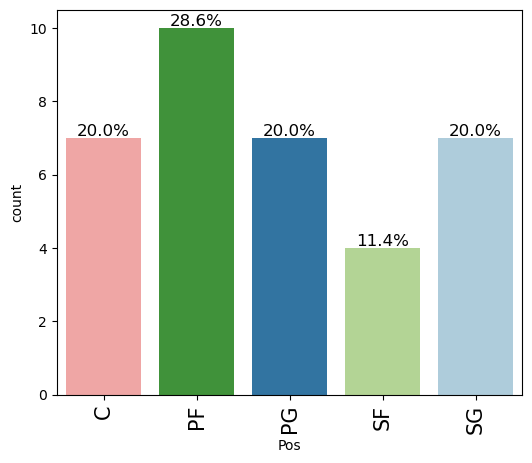

In [30]:
labeled_barplot(df[df['MVP'] == 1], "Pos", perc=True)


> - Power forwards have produced the highest share of MVP seasons, while centers, point guards, and shooting guards contribute evenly, and small forwards account for the lowest share.

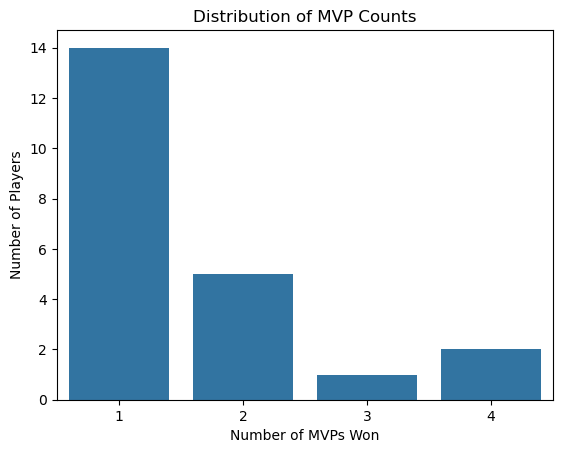

In [31]:
counts = df[df["MVP"]==1]["Player"].value_counts()
sns.countplot(x=counts.values)
plt.title("Distribution of MVP Counts")
plt.xlabel("Number of MVPs Won")
plt.ylabel("Number of Players")
plt.show()


> - This chart shows that most MVPs in NBA since 1991 are one-time winners, while only a small handful of players have ever won multiple MVP awards, making repeat MVP seasons extremely rare.

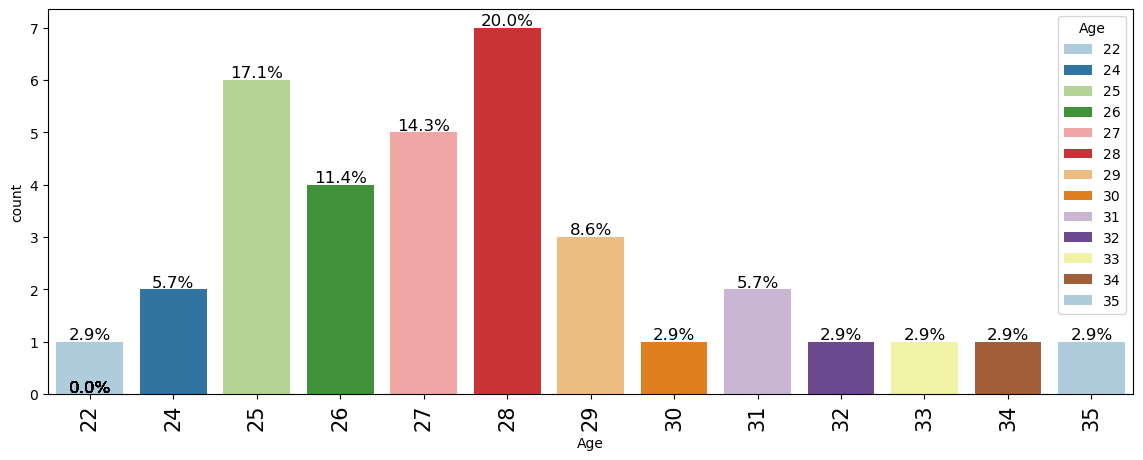

In [32]:
labeled_barplot(df[df['MVP']==1], "Age", perc=True)

> - Most MVP winners fall between ages **25 and 29**, with age 28 being the peak, showing that players typically reach MVP-level performance in their late twenties.

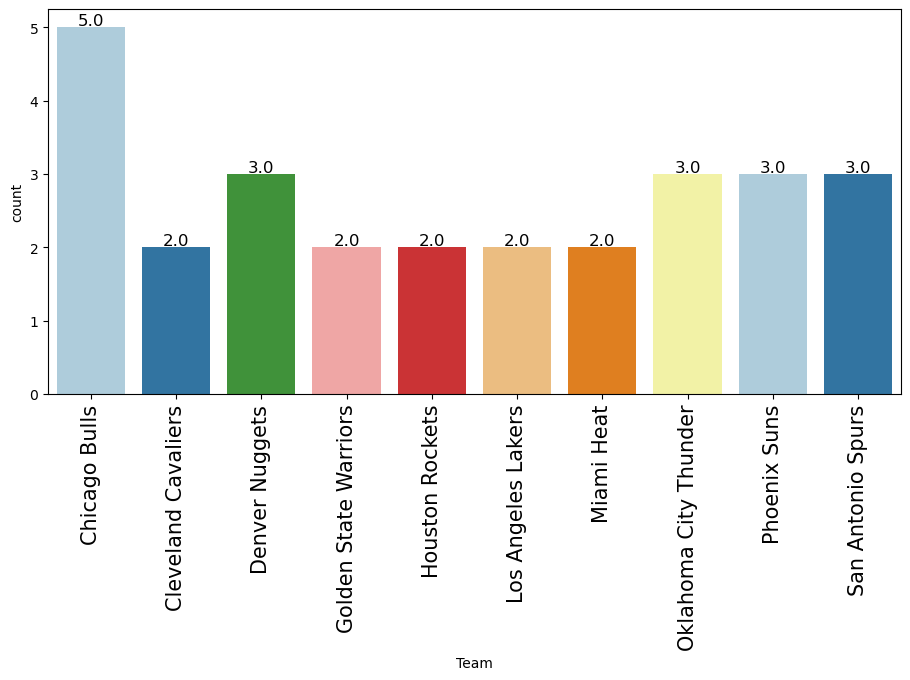

In [33]:
labeled_barplot(df[df['MVP']==1], "Team", n=10)

> - Since 1991, The Chicago Bulls have produced the most MVP seasons in your dataset, followed by several teams tied with 2–3 MVP seasons each, showing that MVPs tend to come from historically strong, high-performing franchises.

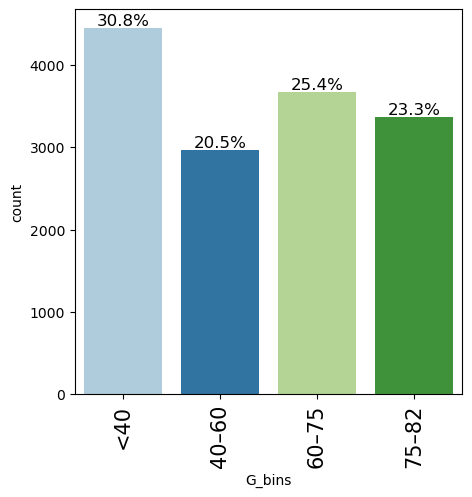

In [34]:
df["G_bins"] = pd.cut(df["G"], bins=[0, 40, 60, 75, 82], labels=["<40", "40–60", "60–75", "75–82"])
labeled_barplot(df, "G_bins", perc=True)

> - Most players in the dataset fall into the lowest games-played category **(<40 games)**, while the distribution becomes more balanced in higher ranges, suggesting that the league has many short-season or partial-season players compared to full-season contributors.

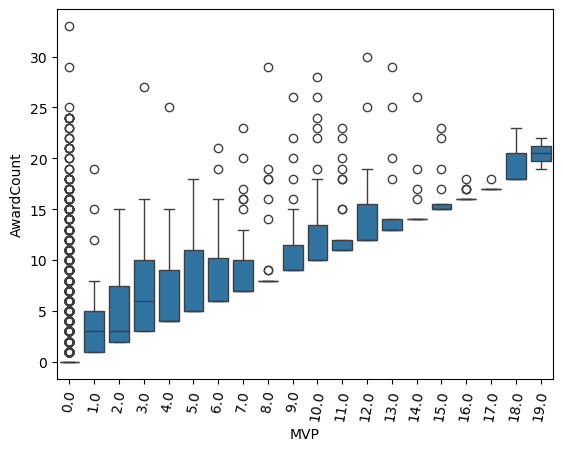

In [35]:
sns.boxplot(data=df, x="MVP", y="AwardCount")
plt.xticks(rotation=80)
plt.show()

> - As the MVP value increases, players tend to have significantly higher AwardCount totals, showing that MVP winners are usually players who have already accumulated multiple major awards throughout their careers.

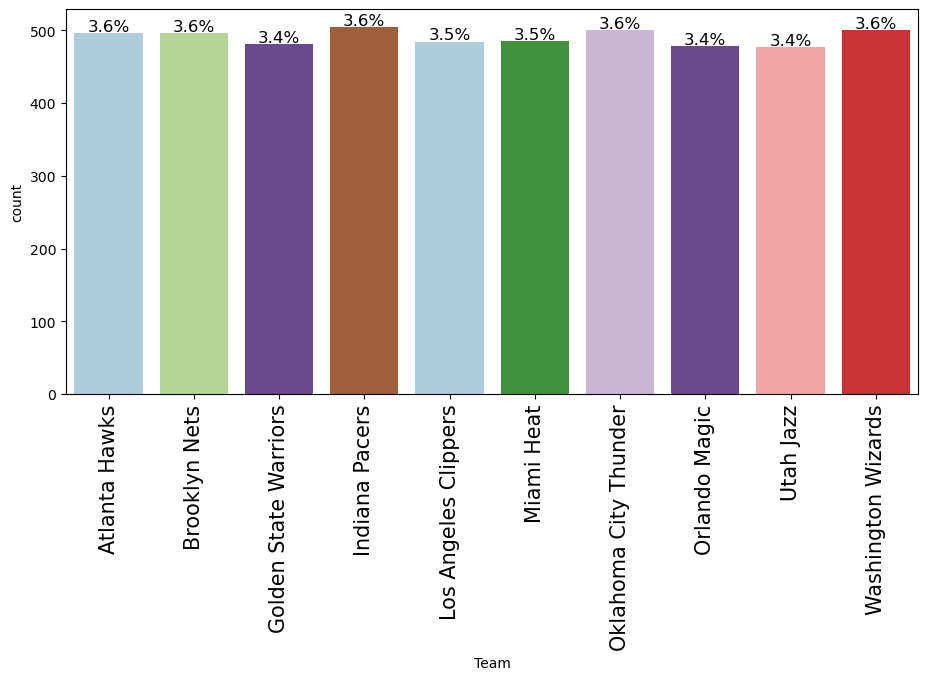

In [36]:
labeled_barplot(df[df['MVP'] == 0], "Team", n=10, perc=True)

> - Since 1991, These teams consistently appear in seasons without an MVP winner, indicating they produce high player volume but rarely generate MVP-level performances.

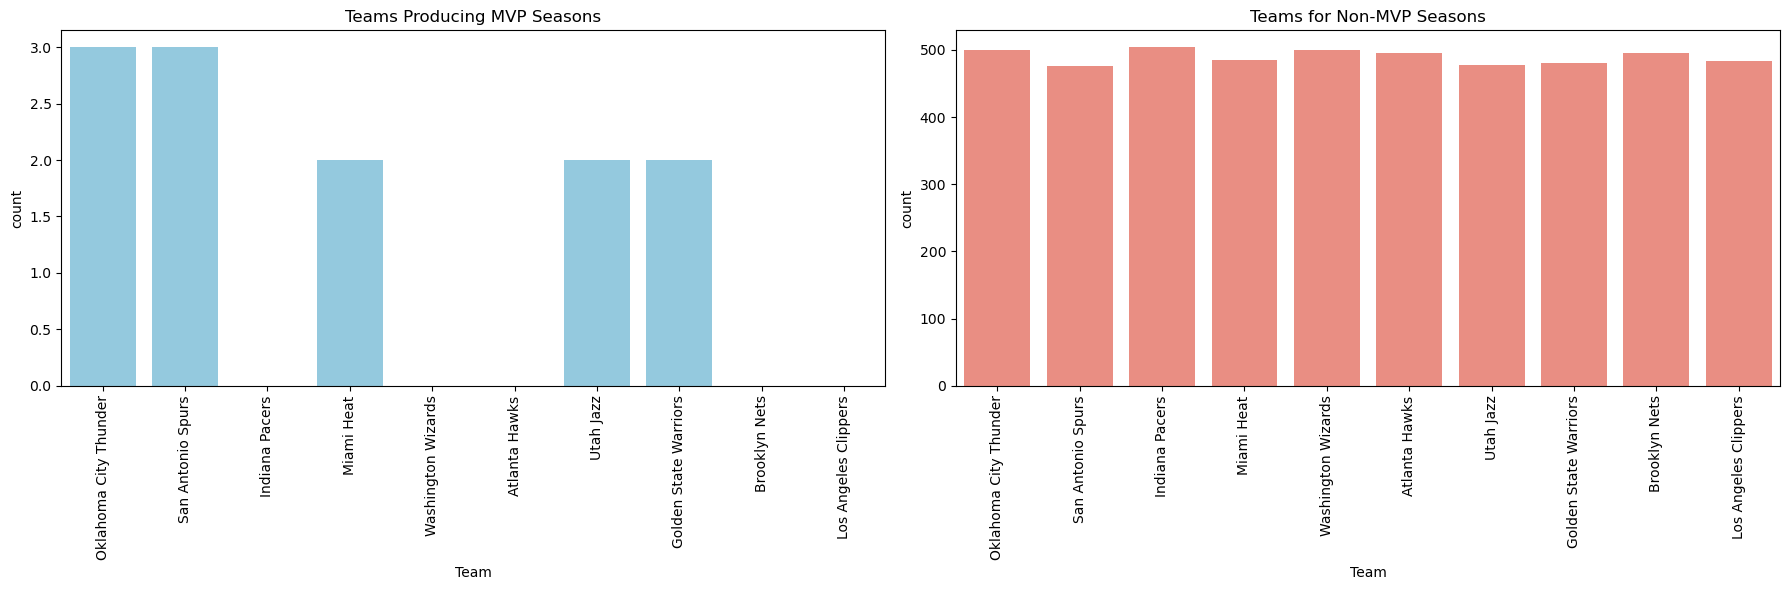

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(
    data=df[df['MVP'] == 1],
    x="Team",
    order=df['Team'].value_counts().index[:10],
    ax=axes[0],
    color="skyblue"
)
axes[0].set_title("Teams Producing MVP Seasons")
axes[0].tick_params(axis='x', rotation=90)

sns.countplot(
    data=df[df['MVP'] == 0],
    x="Team",
    order=df['Team'].value_counts().index[:10],
    ax=axes[1],
    color="salmon"
)
axes[1].set_title("Teams for Non-MVP Seasons")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


> - A small cluster of teams repeatedly produces MVP seasons, while the rest of the league shows high participation in non-MVP seasons, highlighting how rare and concentrated MVP-level performance truly is across franchises.

In [38]:
df["MVP_binary"] = (df["MVP"] == 1).astype(int)

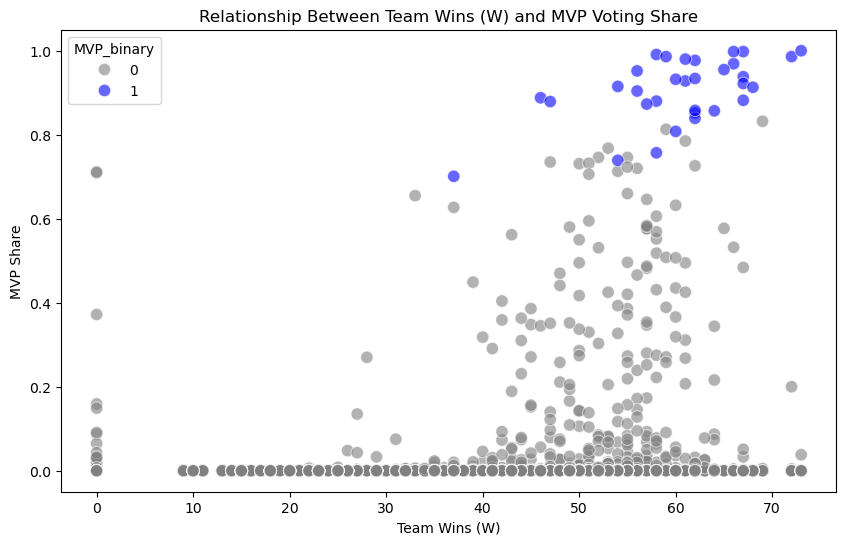

In [39]:
# df['MVP_binary'] = (df['MVP'] == 1).astype(int)

plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df,
    x="W",
    y="Share",
    hue="MVP_binary",
    palette={0:"gray", 1:"blue"},
    alpha=0.6,
    s=80
)

plt.title("Relationship Between Team Wins (W) and MVP Voting Share")
plt.xlabel("Team Wins (W)")
plt.ylabel("MVP Share")
plt.show()


> - The scatterplot reveals that while low-win teams occasionally produce players with moderate voting share, nearly all true MVP winners (in blue) come from top-winning teams; indicating that voters heavily favor elite individual seasons that also translate into elite team success.

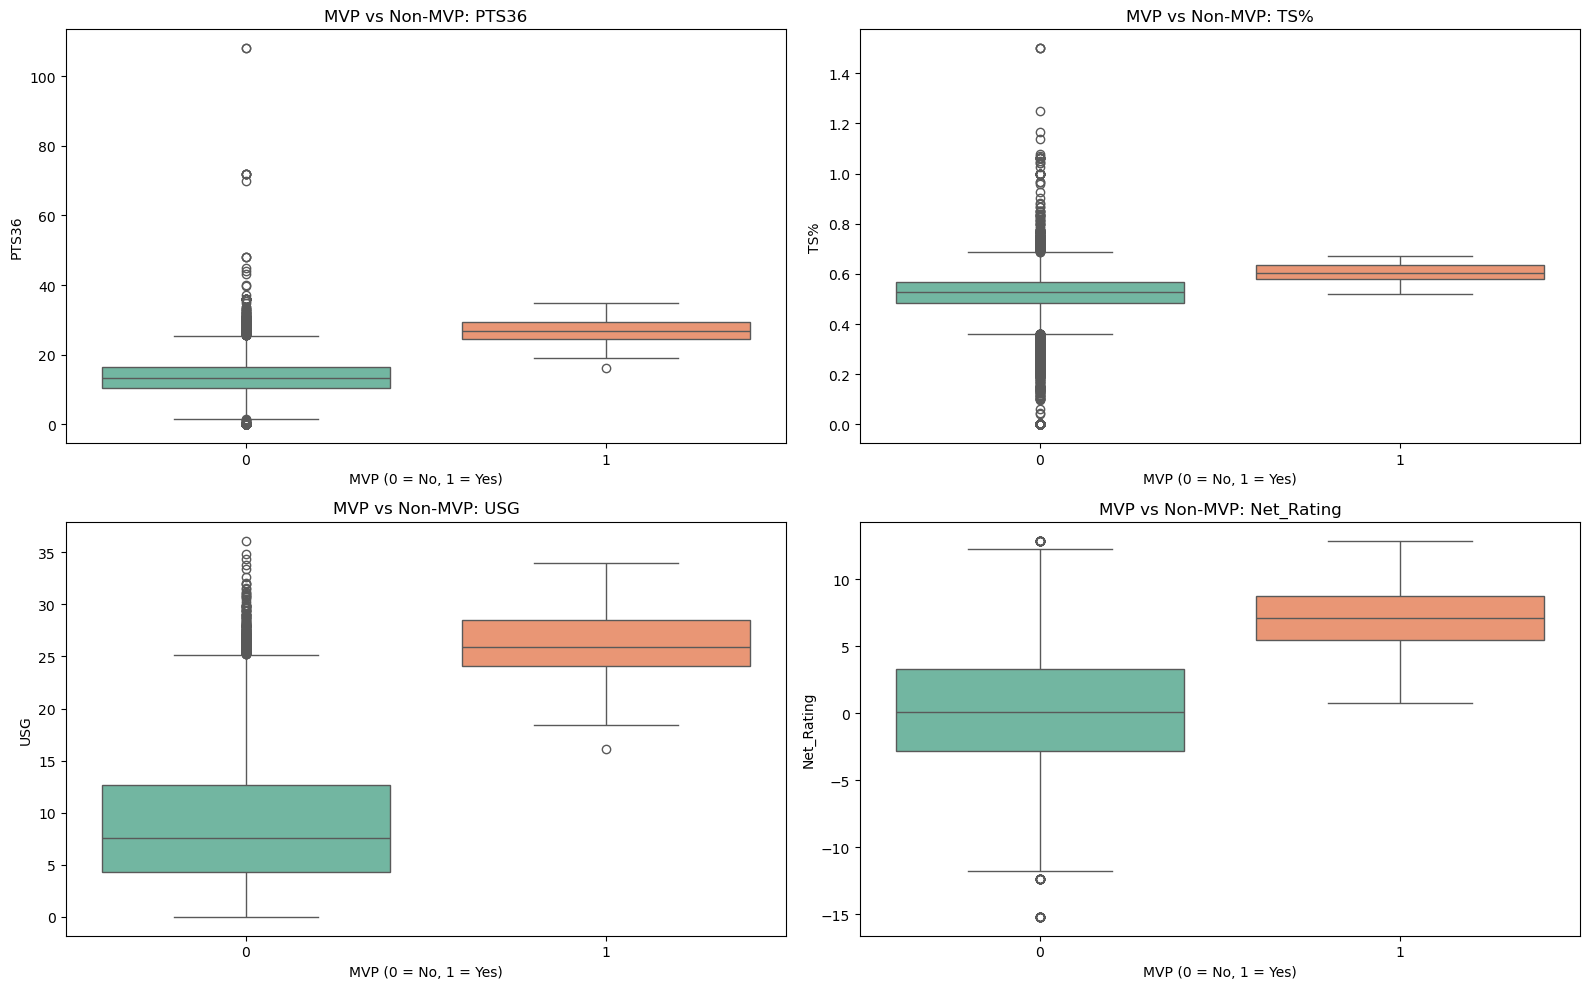

In [40]:
metrics = ["PTS36", "TS%", "USG", "Net_Rating"]

plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="MVP_binary", y=metric, palette="Set2")
    plt.title(f"MVP vs Non-MVP: {metric}")
    plt.xlabel("MVP (0 = No, 1 = Yes)")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


> - **PTS36** - MVP players score significantly more per 36 minutes compared to non-MVP players.
> - **TS%** - MVPs score more efficiently, with higher median TS% values and Non-MVPs show heavy outliers, including many very inefficient seasons.
> - **USG** - MVPs carry a **substantially heavier offensive load** and MVP usage rates are clustered around the upper end of league norms, while non-MVPs include role players with single-digit usage.
> - **Net Rating** - MVP seasons show stronger positive on-court impact, with higher overall Net Ratings and non-MVP seasons have a much wider range — including many negative values — indicating inconsistent team impact.

**Summary**: MVP seasons are defined by higher scoring, better efficiency, heavier offensive responsibility, and superior on-court impact — clear, consistent indicators that statistically separate MVPs from the rest of the league.

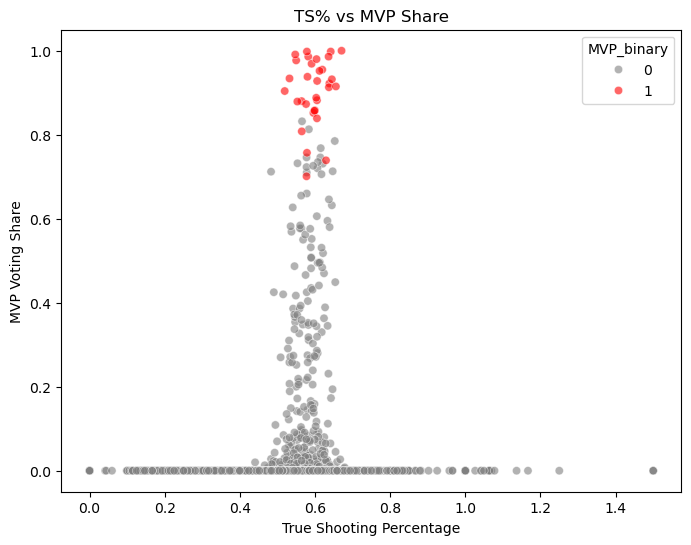

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, 
    x="TS%", 
    y="Share", 
    hue="MVP_binary",
    palette={0:"gray", 1:"red"},
    alpha=0.6
)
plt.title("TS% vs MVP Share")
plt.xlabel("True Shooting Percentage")
plt.ylabel("MVP Voting Share")
plt.show()


**TS% vs MVP Share**

> - MVP winners (in red) cluster around **TS% ≈ 0.60–0.65**.

> - Non-MVP seasons (gray) are spread everywhere but mostly lower.

> - Players with extremely high TS% (>0.70) do not automatically get MVP — efficiency alone isn’t enough.

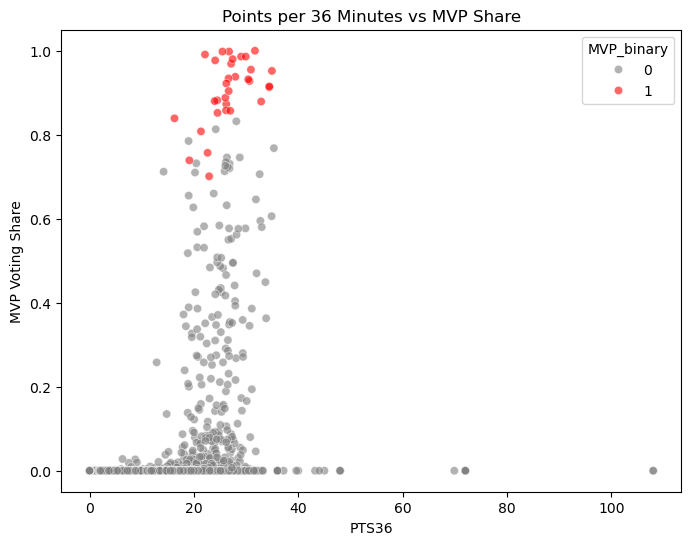

In [42]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="PTS36", y="Share", hue="MVP_binary", palette={0:"gray", 1:"red"}, alpha=0.6)
plt.title("Points per 36 Minutes vs MVP Share")
plt.xlabel("PTS36")
plt.ylabel("MVP Voting Share")
plt.show()


**Points per 36 Minutes (PTS36) vs MVP Share**

> - MVP seasons cluster around **26–32 points per 36 minutes**.

> - Non-MVP players rarely reach this scoring tier.

> - Extreme outliers (50–100 PTS36) are role players with tiny minutes — they don’t get MVP votes.

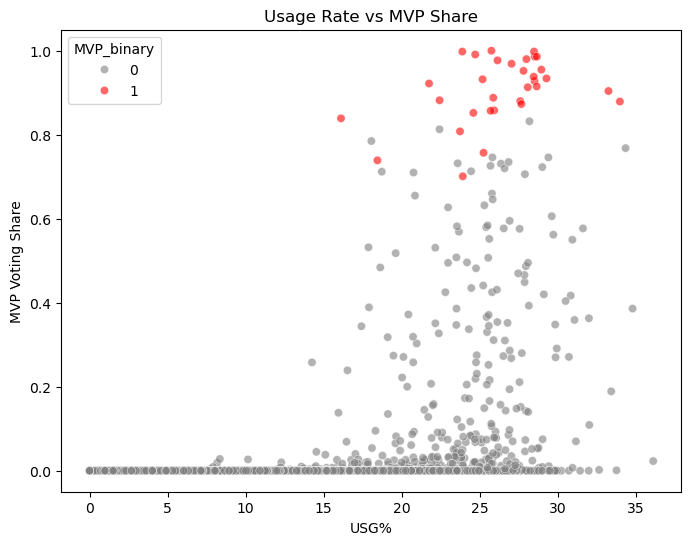

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="USG", y="Share", hue="MVP_binary", palette={0:"gray", 1:"red"}, alpha=0.6)
plt.title("Usage Rate vs MVP Share")
plt.xlabel("USG%")
plt.ylabel("MVP Voting Share")
plt.show()


**Usage Rate (USG%) vs MVP Share**

> - MVPs almost exclusively fall within **28–35% usage**.
    
> - Lower-usage players (<20%) almost never receive MVP-level voting share.

> - There’s a clear “MVP zone” of **high responsibility + high impact**.

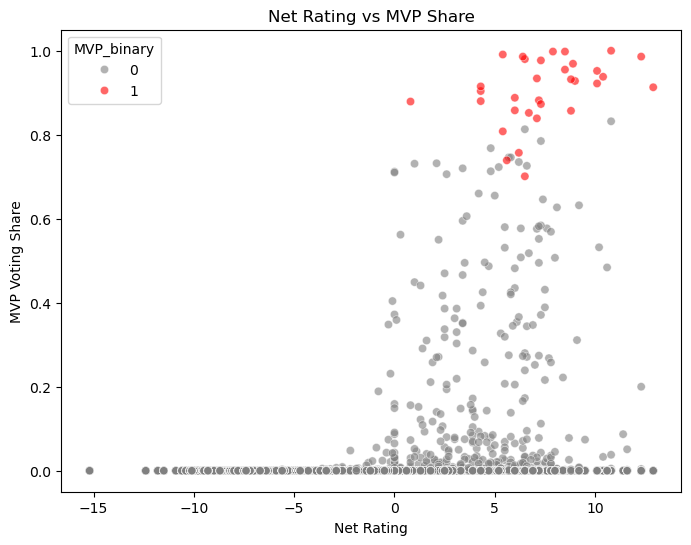

In [44]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Net_Rating", y="Share", hue="MVP_binary", palette={0:"gray", 1:"red"}, alpha=0.6)
plt.title("Net Rating vs MVP Share")
plt.xlabel("Net Rating")
plt.ylabel("MVP Voting Share")
plt.show()


**Net Rating vs MVP Share**

> - MVPs cluster around **+5 to +12 net rating**.

> - Non-MVP players cover a wide range from **–15 to +15**, including negatives.

> - High net rating alone doesn’t predict MVP, but all MVPs are in the positive-impact zone.

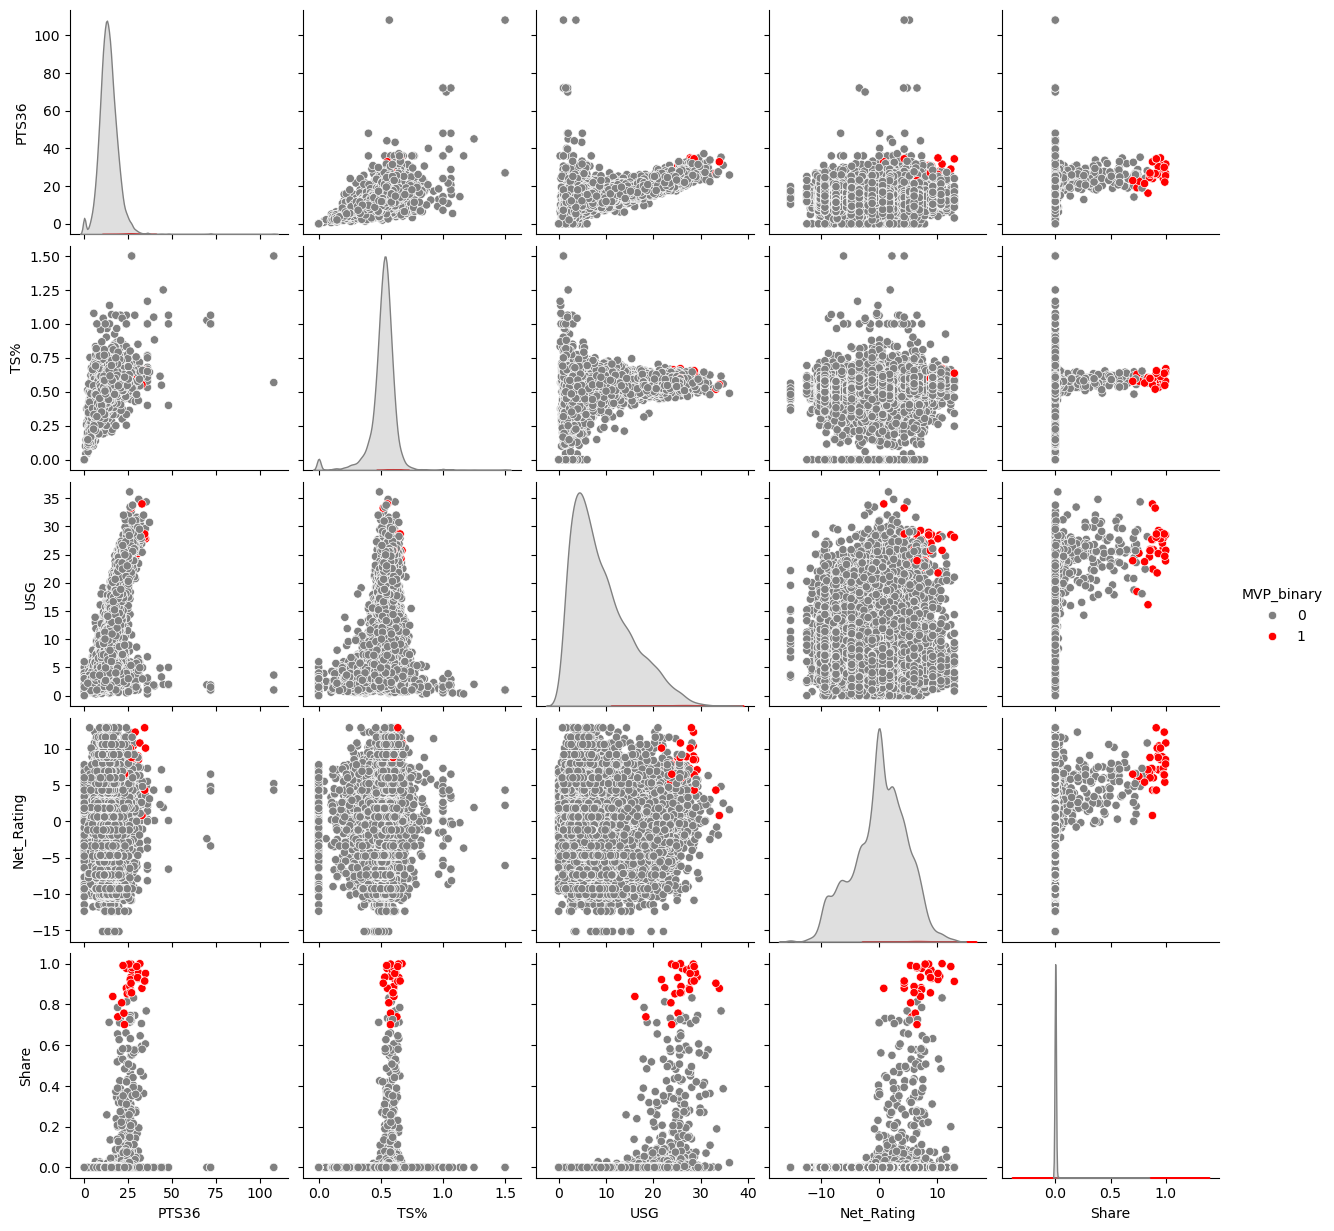

In [45]:
top_feats = ["PTS36", "TS%", "USG", "Net_Rating", "Share", "MVP_binary"]
sns.pairplot(df[top_feats], hue="MVP_binary", palette={0:"gray", 1:"red"}, diag_kind="kde")
plt.show()


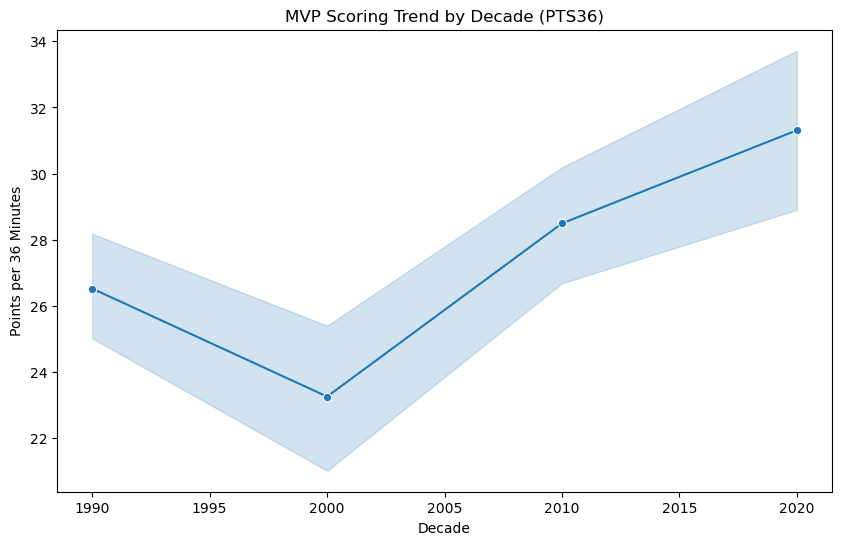

In [46]:
df["Decade"] = (df["Year"] // 10) * 10

mvp_only = df[df["MVP"] == 1]

plt.figure(figsize=(10,6))
sns.lineplot(data=mvp_only, x="Decade", y="PTS36", marker="o")
plt.title("MVP Scoring Trend by Decade (PTS36)")
plt.ylabel("Points per 36 Minutes")
plt.xlabel("Decade")
plt.show()


**MVP Scoring Trend by Decade (PTS36)**

MVP expectations have risen over time.
Modern offenses emphasize pace, spacing, and efficiency, so MVPs now produce:

- More scoring volume

- More offensive responsibility

- Higher efficiency (supported by rising TS% in later charts)

- Modern MVPs score **30–33 points per 36 minutes**, much higher than in the 90s

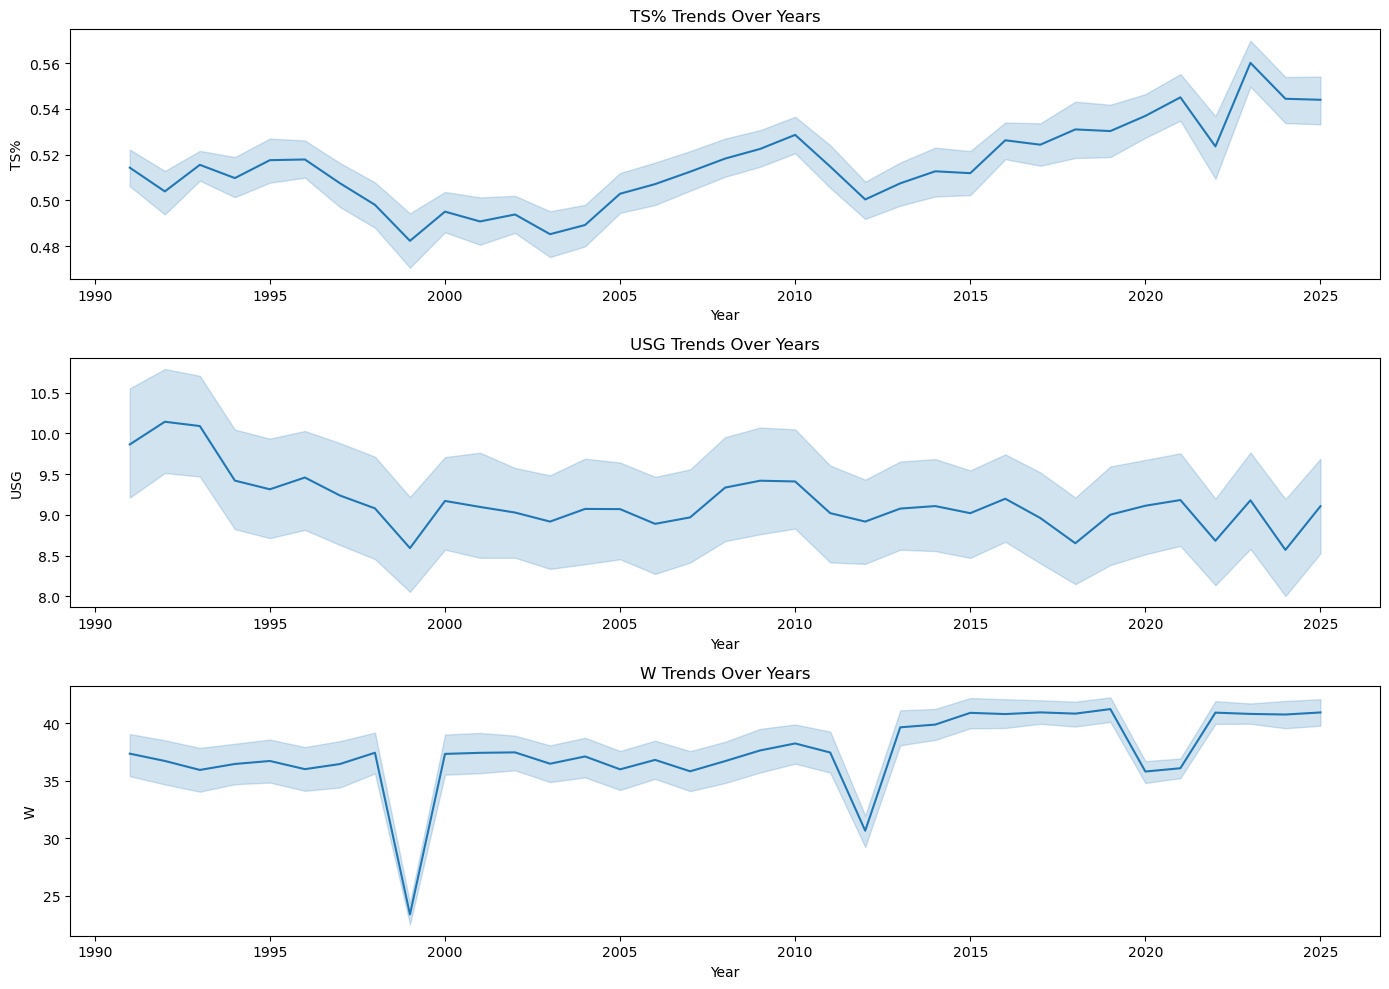

In [47]:
plt.figure(figsize=(14,10))

metrics = ["TS%", "USG", "W"]

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(data=df, x="Year", y=metric)
    plt.title(f"{metric} Trends Over Years")
    plt.xlabel("Year")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


**TS% (Shooting Efficiency) Trend**

- Gradual upward trend across decades

- Slight dips around 2000 and mid-2010s

- Peaks in 2020–2023 era due to analytics, spacing, and rule changes

**USG% (Usage Rate) Trend**

- Slight downward trend with fluctuations

- Peaks in early 90s and mid-2000s

- More balanced team offenses in the modern era - moderate usage but high efficiency.

**Wins Trend (W) Over Time**

- Team wins for MVPs typically stay in the 35–40+ range

- Some notable dips **(2000, 2010, 2020, 2021)** due to shortened seasons or context

- Modern MVPs continue to come from top-winning teams


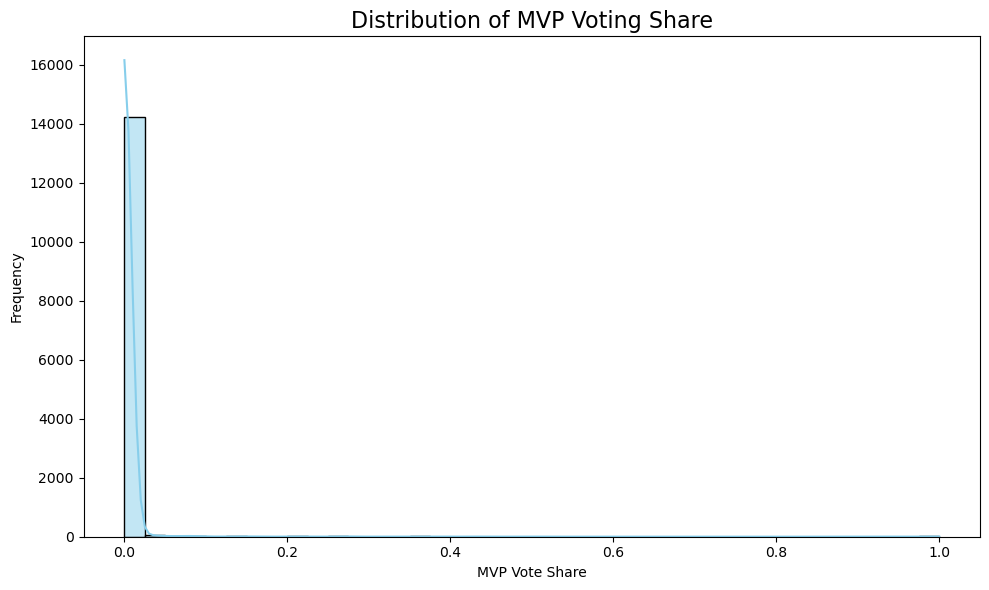

In [48]:
plt.figure(figsize=(10,6))

sns.histplot(
    data=df,
    x="Share",
    bins=40,
    kde=True,
    color="skyblue"
)

plt.title("Distribution of MVP Voting Share", fontsize=16)
plt.xlabel("MVP Vote Share")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The MVP voting system is **highly exclusive**.
Only a tiny number of players ever receive votes, and only one becomes MVP.

In [49]:
df["MVP_binary"] = df["MVP_binary"].astype(int)

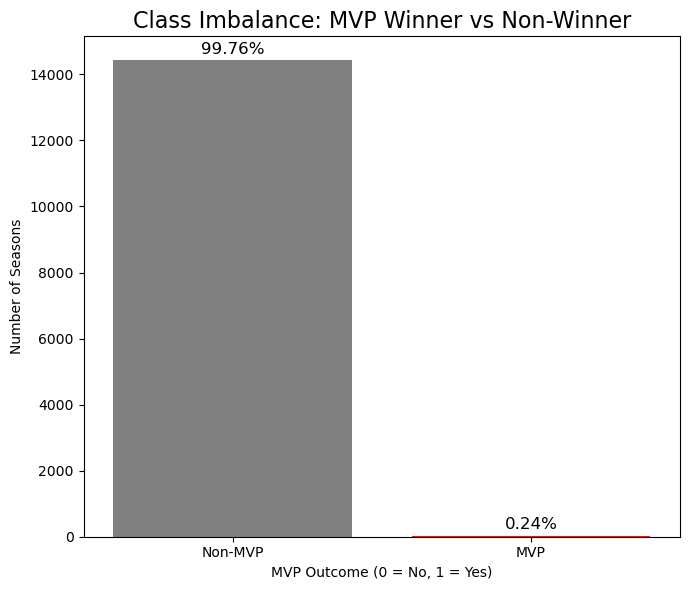

In [50]:
plt.figure(figsize=(7,6))

sns.countplot(
    data=df,
    x="MVP_binary",
    hue="MVP_binary",
    palette={0: "gray", 1: "red"},
    legend=False
)

# Add percentage labels
counts_raw = df["MVP_binary"].value_counts()
counts_pct = df["MVP_binary"].value_counts(normalize=True)

for i, (cls, v) in enumerate(counts_raw.items()):
    perc = counts_pct[cls] * 100
    plt.text(i, v + 200, f"{perc:.2f}%", ha="center", fontsize=12)

plt.title("Class Imbalance: MVP Winner vs Non-Winner", fontsize=16)
plt.xlabel("MVP Outcome (0 = No, 1 = Yes)")
plt.ylabel("Number of Seasons")
plt.xticks([0,1], ["Non-MVP", "MVP"])
plt.tight_layout()
plt.show()


- The dataset is extremely imbalanced.


In [51]:
df.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards',
       'Year', 'MIP', '6MOY', 'ROY', 'DPOY', 'MVP', 'CPOY', 'Pts Won',
       'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS',
       'TS%', 'USG', 'PTS36', 'AST36', 'TRB36', 'Net_Rating', 'EFF',
       'AwardCount', 'Poss', 'ORtg', 'DRtg', 'WS_approx', 'G_bins',
       'MVP_binary', 'Decade'],
      dtype='object')

In [52]:
corr_features = [
    'Age','G','GS','MP',
    'FG','FGA','FG%', 
    '3P','3PA','3P%',
    '2P','2PA','2P%',
    'eFG%','FT','FTA','FT%',
    'ORB','DRB','TRB',
    'AST','STL','BLK','TOV','PF',
    'PTS','TS%','USG',
    'PTS36','AST36','TRB36',
    'Net_Rating','EFF','Poss',
    'ORtg','DRtg','WS_approx',
    'W','L','W/L%','GB','PS/G','PA/G','SRS', 'MVP_binary'
]


In [53]:
df[corr_features + ['Share']].corr()['Share'].sort_values(ascending=False)

Share         1.000000
MVP_binary    0.682125
FTA           0.329067
FT            0.322633
EFF           0.285129
PTS           0.283929
2P            0.277606
FG            0.271978
Poss          0.263654
USG           0.263654
2PA           0.255793
FGA           0.246084
TOV           0.229989
PTS36         0.222807
DRB           0.211599
AST           0.194118
TRB           0.184722
STL           0.172651
GS            0.165627
MP            0.160032
BLK           0.156438
SRS           0.121067
Net_Rating    0.121029
AST36         0.111375
W/L%          0.105391
W             0.103910
ORB           0.097747
G             0.089239
3PA           0.084034
3P            0.083147
PF            0.074577
ORtg          0.071423
TS%           0.068653
FG%           0.059855
TRB36         0.054174
2P%           0.051073
eFG%          0.050054
FT%           0.037264
3P%           0.027701
Age           0.023864
PS/G          0.021485
PA/G          0.001180
WS_approx    -0.018265
DRtg       

In [54]:
corr_matrix = df[corr_features].corr()

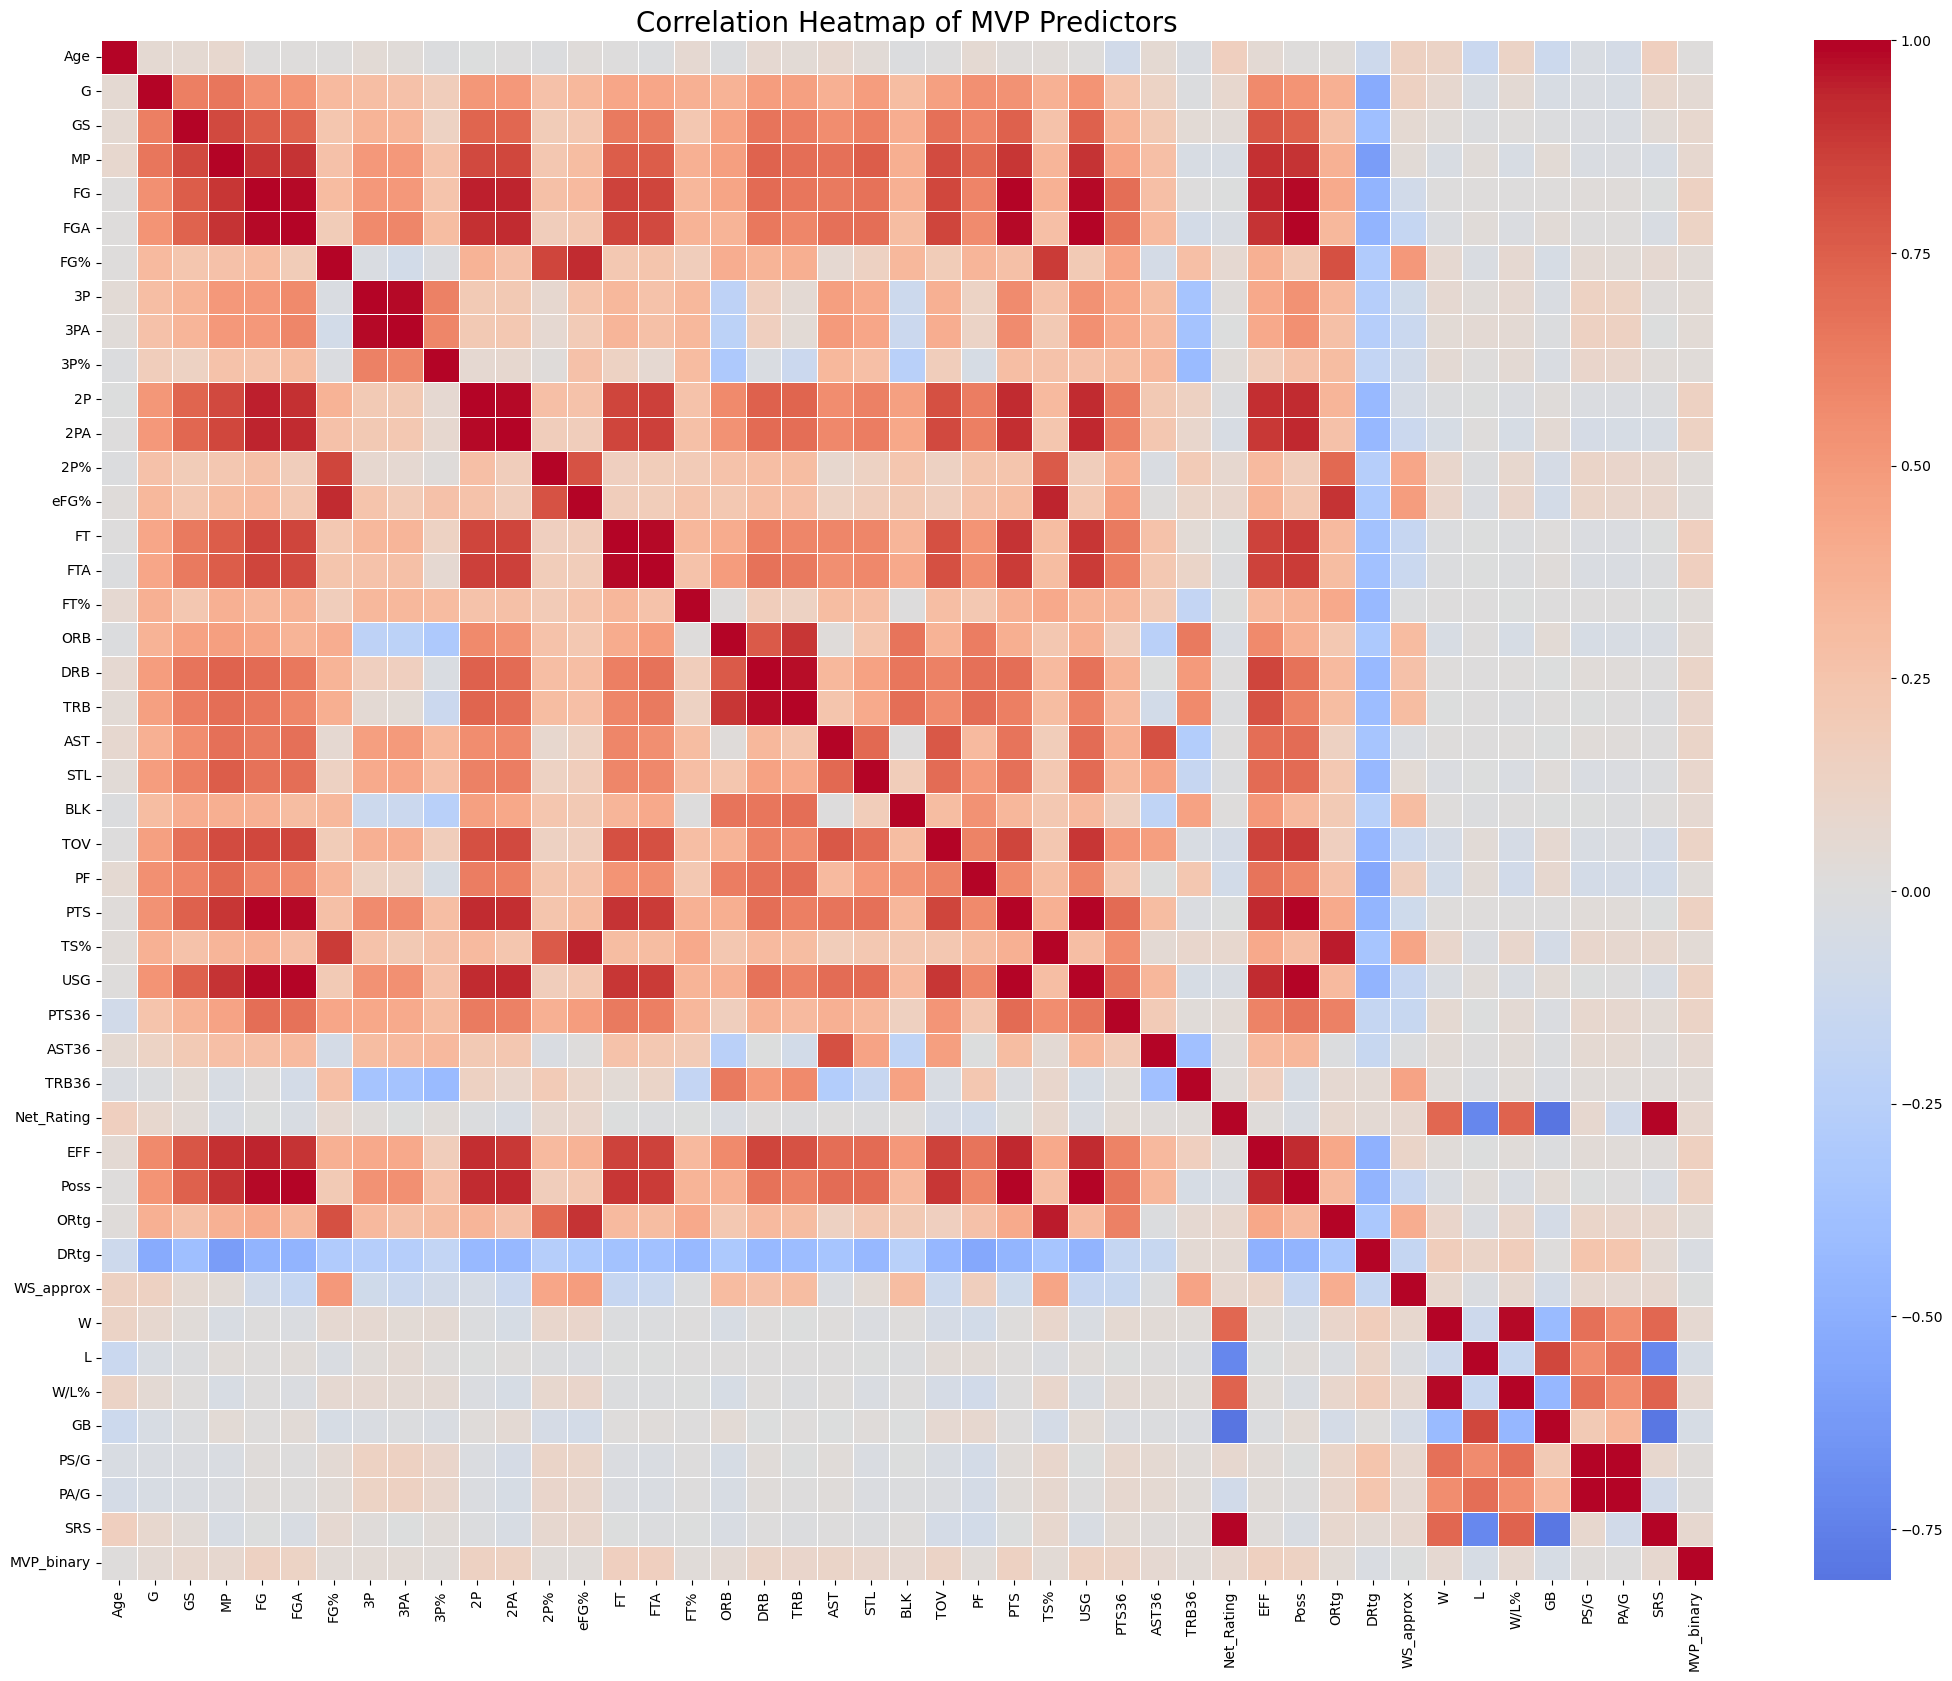

In [55]:
plt.figure(figsize=(26, 20))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("Correlation Heatmap of MVP Predictors", fontsize=20)
plt.show()


Your correlation analysis clearly shows that MVP voting is driven primarily by elite offensive volume and all-around statistical impact, rather than team success or defensive metrics.

Surprisingly, **three-point shooting** metrics, **age**, **defensive rating**, and even **team wins** show very weak correlations, suggesting that the MVP award is far less about efficiency, team record, or defense than commonly believed.

Several variables—like **PA/G, GB, DRtg, WS_approx, and losses—add** virtually no predictive value and can be safely removed from modeling.

In [56]:
df['Pos'].value_counts()

Pos
SG    3060
PF    2992
C     2973
PG    2724
SF    2715
F        1
Name: count, dtype: int64

In [57]:
df['Pos'] = df['Pos'].replace({'F': 'SF'})


In [58]:


df = pd.get_dummies(df, columns=['Pos'], prefix='Pos', drop_first=True)

# Convert boolean → 0/1
pos_cols = [col for col in df.columns if col.startswith('Pos_')]
df[pos_cols] = df[pos_cols].astype(int)


In [59]:
df.columns

Index(['Player', 'Age', 'Team', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Awards', 'Year',
       'MIP', '6MOY', 'ROY', 'DPOY', 'MVP', 'CPOY', 'Pts Won', 'Pts Max',
       'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS', 'TS%', 'USG',
       'PTS36', 'AST36', 'TRB36', 'Net_Rating', 'EFF', 'AwardCount', 'Poss',
       'ORtg', 'DRtg', 'WS_approx', 'G_bins', 'MVP_binary', 'Decade', 'Pos_PF',
       'Pos_PG', 'Pos_SF', 'Pos_SG'],
      dtype='object')

In [60]:
df['Pos_SF']

0        0
1        1
2        1
3        0
4        0
        ..
14460    1
14461    0
14462    0
14463    0
14464    0
Name: Pos_SF, Length: 14465, dtype: int64

# Model evaluation criterion

### Model can make wrong predictions as:

1. **The model predicts a player is MVP-level, but in reality, the player did not win MVP**  
   - This is a False Positive.  
   - Consequence: The model overestimates a player’s MVP candidacy, which may inflate rankings or attention on players who ultimately did not receive MVP votes.  
   - Impact: Minor loss in interpretability or credibility, but not critical as long as the true MVP is identified.

2. **The model predicts a player is not MVP-level, but in reality, the player did win MVP**  
   - This is a False Negative.  
   - Consequence: The model completely misses the actual MVP.  
   - Impact: Critical failure, as the model fails its primary objective of identifying the most valuable player.

### Which case is more important?

- Avoiding False Negatives is more important.  
- Missing the real MVP means the model fails to capture the most impactful player of the season.

### How each metric fits into this decision?

- **Recall** answers the key question:  
  *Of all real MVPs, how many did the model correctly identify?*

- High Recall means fewer False Negatives and a lower chance of missing the actual MVP.

- **Precision** is less critical, since identifying extra MVP-level candidates is acceptable as long as the true MVP is included.

- **Accuracy** can be misleading due to extreme class imbalance between MVPs and non-MVPs.

- **F1 Score** balances Precision and Recall, but Recall should be prioritized when the objective is to never miss the MVP.


In [61]:
rf_features = [
    # Scoring
    'PTS', 'PTS36', 'FT', 'FTA', 'FG', 'FGA', '2P', '2PA',

    # Usage / role
    'USG', 'Poss', 'Net_Rating', 'ORtg', 'DRtg',

    # Efficiency
    'TS%', 'eFG%', 'FG%', '2P%', '3P%', 'FT%',

    # Rebounds, assists, defense
    'AST', 'AST36', 'TRB', 'TRB36', 'DRB', 'STL', 'BLK', 'TOV',

    # Team performance
    'W', 'W/L%', 'SRS', 'PS/G', 'PA/G',

    # Context
    'G', 'GS', 'MP', 'Year',

    'MVP_binary',  'Share',
    
    'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG'
]


### **Data Preparation for Modeling**

In [62]:
data = df[rf_features]
y = data['MVP_binary']
X = data.drop(['Share', 'MVP_binary'], axis=1)

In [63]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=1,
    stratify=y_temp
)

In [64]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [65]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Decision Tree

In [66]:
dtree = DecisionTreeClassifier(criterion= 'gini', random_state=1, class_weight = {0: 1, 1: 400})
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 400}, random_state=1)

In [67]:
X_train

,PTS,PTS36,FT,FTA,FG,FGA,2P,2PA,USG,Poss,...,PS/G,PA/G,G,GS,MP,Year,Pos_PF,Pos_PG,Pos_SF,Pos_SG
4567,9.6,16.074419,3.1,3.6,2.9,6.1,2.2,4.5,8.784,8.784,...,93.3,94.0,76,11,21.5,2004,1,0,0,0
3293,12.8,15.889655,1.2,1.4,4.8,10.0,2.9,5.4,11.916,11.916,...,97.9,100.8,70,42,29.0,2017,0,1,0,0
8940,14.8,16.343558,1.6,1.9,6.0,13.4,4.7,10.0,16.536,16.536,...,99.4,98.6,40,37,32.6,2015,0,1,0,0
100,5.0,11.538462,0.8,1.1,2.1,4.8,2.1,4.7,5.984,5.984,...,95.9,92.3,77,8,15.6,1998,0,0,1,0
3446,1.5,5.142857,0.6,0.7,0.4,1.3,0.4,1.0,2.208,2.208,...,99.7,107.6,40,4,10.5,1992,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,2.2,10.560000,0.8,1.3,0.7,1.2,0.7,1.0,2.072,2.072,...,0.0,0.0,6,0,7.5,2012,0,0,1,0
2145,6.1,9.847534,2.3,3.4,1.9,4.5,1.9,4.5,7.096,7.096,...,89.7,96.0,35,8,22.3,2004,1,0,0,0
2483,1.6,8.470588,0.4,0.5,0.5,1.4,0.3,0.7,2.220,2.220,...,101.2,97.1,22,0,6.8,1994,0,0,0,1
951,12.4,15.773852,2.0,2.3,4.3,9.2,2.5,4.5,11.412,11.412,...,117.9,111.4,82,70,28.3,2023,0,0,0,1


In [68]:
model_performance_classification_sklearn(dtree, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


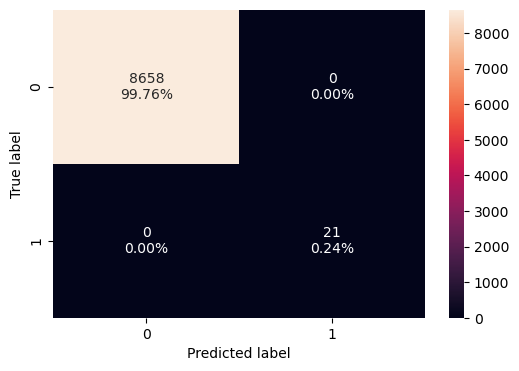

In [69]:
confusion_matrix_sklearn(dtree, X_train, y_train)

In [70]:
model_performance_classification_sklearn(dtree, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.998617,0.714286,0.714286,0.714286


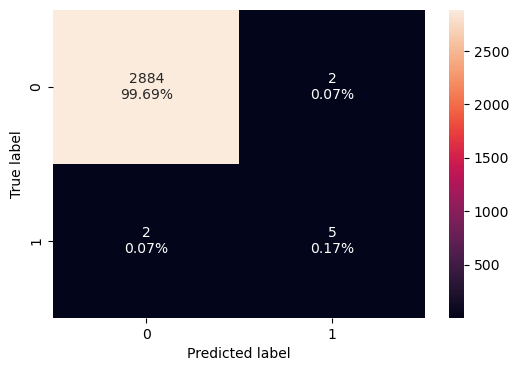

In [71]:
confusion_matrix_sklearn(dtree, X_val, y_val)

> For the Decision Tree, the model perfectly memorizes the training data (100% on all metrics), but on validation it **overfits**, achieving high accuracy due to class imbalance while only correctly identifying about **71%** of true MVPs, meaning nearly **3 out of 10 real MVPs** are still missed.

#### Bagging Classifier

In [72]:
bagging_estimator = BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train, y_train)

BaggingClassifier(random_state=1)

In [73]:
model_performance_classification_sklearn(bagging_estimator, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.99977,0.904762,1.0,0.95


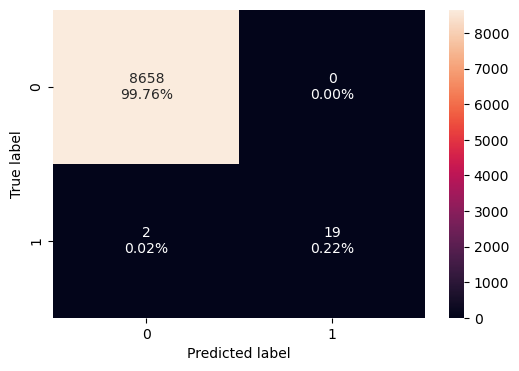

In [74]:
confusion_matrix_sklearn(bagging_estimator, X_train, y_train)

In [75]:
model_performance_classification_sklearn(bagging_estimator, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.998617,0.571429,0.8,0.666667


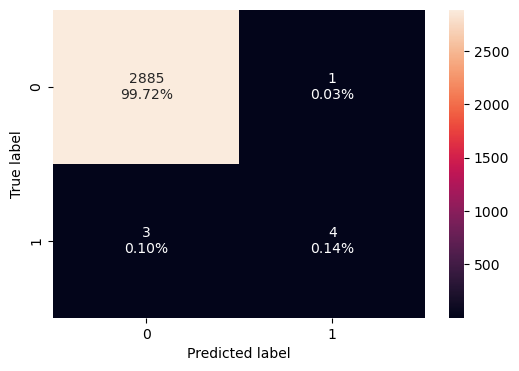

In [76]:
confusion_matrix_sklearn(bagging_estimator, X_val, y_val)

> For the **Bagging Classifier**, the model improves stability over a single decision tree but still **overfits**, as it performs extremely well on training data while only identifying about **57% of true MVPs on validation**, meaning it still misses nearly **half of the real MVPs**, which is risky given recall is the priority.


#### **Bagging with Classifier**

In [77]:
bagging_wt = BaggingClassifier(DecisionTreeClassifier(criterion='gini',class_weight={0: 1, 1: 400},random_state=1),random_state=1)
bagging_wt.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 400},
                                                   random_state=1),
                  random_state=1)

In [78]:
model_performance_classification_sklearn(bagging_wt, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,0.999539,0.809524,1.0,0.894737


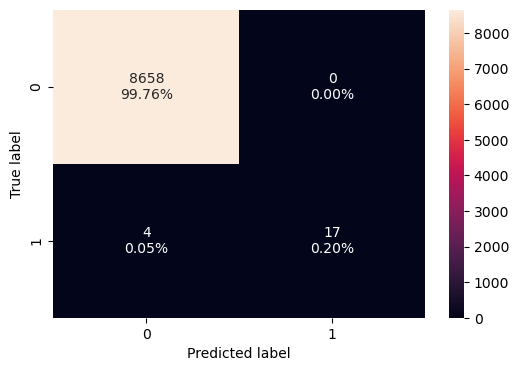

In [79]:
confusion_matrix_sklearn(bagging_wt, X_train, y_train)

In [80]:
model_performance_classification_sklearn(bagging_wt, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.997235,0.0,0.0,0.0


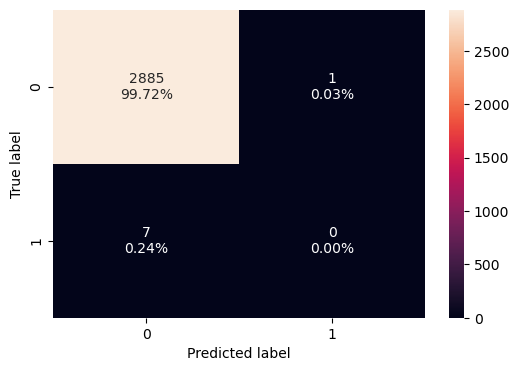

In [81]:
confusion_matrix_sklearn(bagging_wt, X_val, y_val)

> This bagging model with class weights completely fails on validation, achieving **0 recall**, meaning it misses every true MVP.

#### **Random Forest**

In [82]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

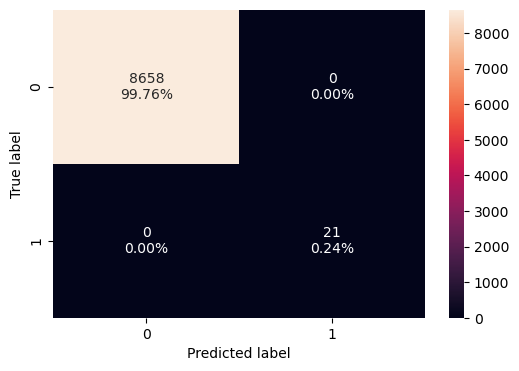

In [83]:
confusion_matrix_sklearn(rf,X_train,y_train)

In [84]:
rf_model_train_perf=model_performance_classification_sklearn(rf,X_train,y_train)
print("Training performance \n",rf_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


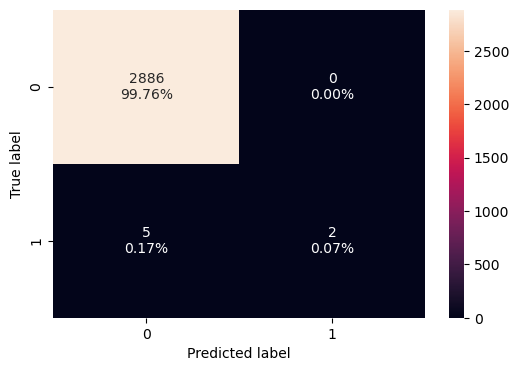

In [85]:
confusion_matrix_sklearn(rf, X_val, y_val)

In [86]:
rf_model_test_perf=model_performance_classification_sklearn(rf, X_val, y_val)
print("Testing performance \n",rf_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.998272  0.285714        1.0  0.444444


> This Random Forest model is severely overfitting, achieving perfect performance on training but very low recall on validation **(≈ 29%)**, meaning it misses most true MVPs,

#### Random forest with class weights

In [87]:
rf_wt = RandomForestClassifier(class_weight={0: 1, 1: 400}, random_state=1)
rf_wt.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 400}, random_state=1)

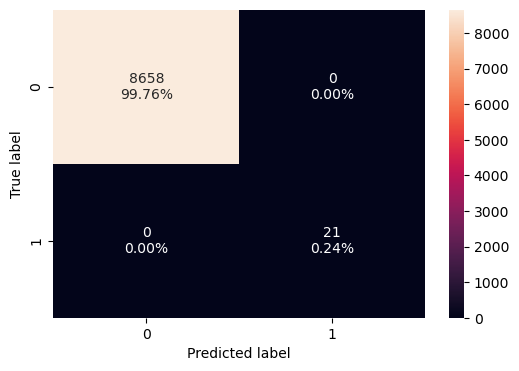

In [88]:
confusion_matrix_sklearn(rf_wt, X_train,y_train)

In [89]:
rf_wt_model_train_perf=model_performance_classification_sklearn(rf_wt, X_val, y_val)
print("Training performance \n",rf_wt_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0  0.997235     0.0        0.0  0.0


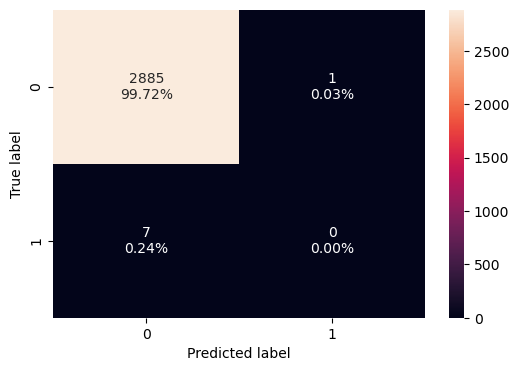

In [90]:
confusion_matrix_sklearn(rf_wt, X_val, y_val)

> This Random Forest with class weights completely collapses on validation, predicting no MVPs at all (recall = 0) despite very high accuracy.

#### Boosting

##### Ada Boosting

In [91]:
ab_regressor = AdaBoostClassifier(random_state=1)
ab_regressor.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

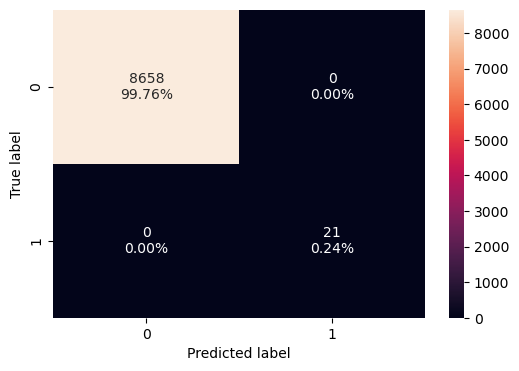

In [92]:
confusion_matrix_sklearn(ab_regressor, X_train, y_train)

In [93]:
model_performance_classification_sklearn(ab_regressor, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


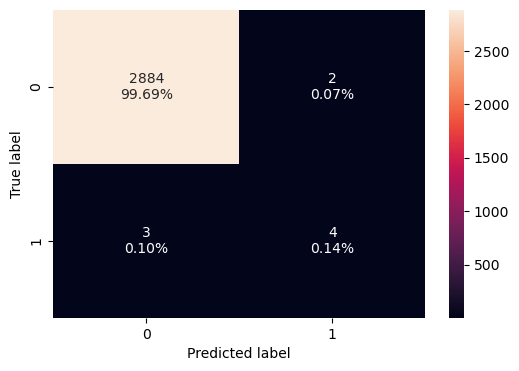

In [94]:
confusion_matrix_sklearn(ab_regressor, X_val, y_val)

In [95]:
model_performance_classification_sklearn(ab_regressor, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.998272,0.571429,0.666667,0.615385


> This AdaBoost model performs perfectly on training but only moderately on validation, correctly identifying about 57% of true MVPs **(recall = 0.57)** with reasonable precision.

#### Gradient Boosting

In [96]:
gb_estimator = GradientBoostingClassifier(random_state =1)
gb_estimator.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

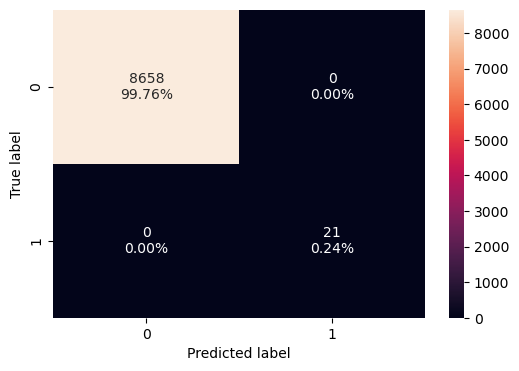

In [97]:
confusion_matrix_sklearn(gb_estimator, X_train, y_train)

In [98]:
model_performance_classification_sklearn(gb_estimator, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


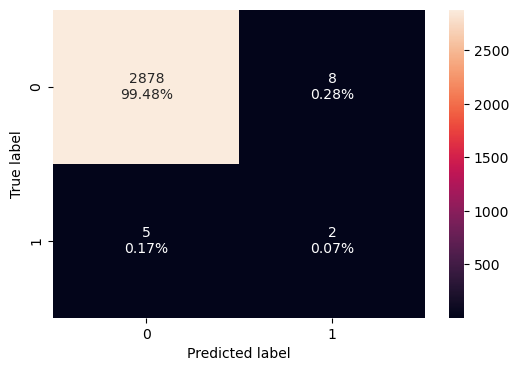

In [99]:
confusion_matrix_sklearn(gb_estimator, X_val, y_val)

In [100]:
model_performance_classification_sklearn(gb_estimator, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.995506,0.285714,0.2,0.235294


> This Gradient Boosting model severely overfits, it is perfect on training but on validation it misses most true MVPs **(recall ≈ 0.29)** and has very low precision.

#### **XGBoost**

In [101]:
xgb_estimator = XGBClassifier(random_state = 1)
xgb_estimator.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

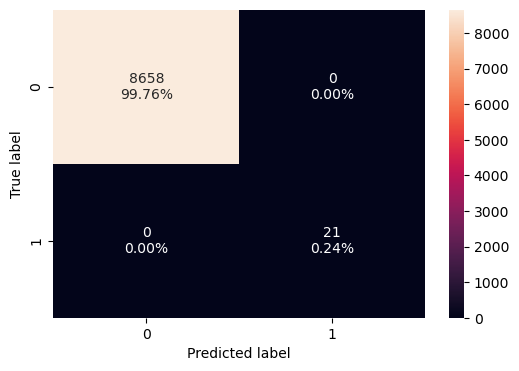

In [102]:
confusion_matrix_sklearn(xgb_estimator, X_train, y_train)

In [103]:
model_performance_classification_sklearn(xgb_estimator, X_train, y_train)

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


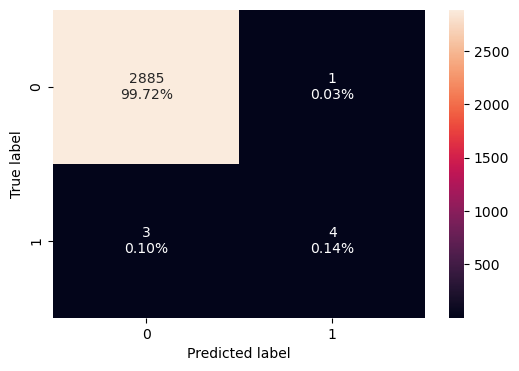

In [104]:
confusion_matrix_sklearn(xgb_estimator, X_val, y_val)

In [105]:
model_performance_classification_sklearn(xgb_estimator, X_val, y_val)

,Accuracy,Recall,Precision,F1
0,0.998617,0.571429,0.8,0.666667


> XGBoost is currently my best-performing model because, on the validation set, it achieves **strong recall (~57%) with high precision (80%)**.


In [106]:
models = []

models.append(("Decision Tree", DecisionTreeClassifier(criterion= 'gini', random_state=1, class_weight={0: 1, 1: 400})))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Bagging with weighted Decision Tree", BaggingClassifier(DecisionTreeClassifier(criterion= 'gini'
                        , random_state=1, class_weight={0: 1, 1: 400}), random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Random Forest with class weights", RandomForestClassifier(class_weight={0: 1, 1: 400}, random_state=1)))
models.append(("Ada Boosting", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoosting", XGBClassifier(random_state=1)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    train_recall = recall_score(y_train, model.predict(X_train))
    print(f"{name}: {train_recall}")


print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    val_recall = recall_score(y_val, model.predict(X_val))
    print(f"{name}: {val_recall}")


Training Performance:

Decision Tree: 1.0
Bagging: 0.9047619047619048
Bagging with weighted Decision Tree: 0.8095238095238095
Random Forest: 1.0
Random Forest with class weights: 1.0
Ada Boosting: 1.0
Gradient Boosting: 1.0
XGBoosting: 1.0

Validation Performance:

Decision Tree: 0.7142857142857143
Bagging: 0.5714285714285714
Bagging with weighted Decision Tree: 0.0
Random Forest: 0.2857142857142857
Random Forest with class weights: 0.0
Ada Boosting: 0.5714285714285714
Gradient Boosting: 0.2857142857142857
XGBoosting: 0.5714285714285714


In [107]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_train = recall_score(y_train, model.predict(X_train))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference1 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference1))


Training and Validation Performance Difference:

Decision Tree: Training Score: 1.0000, Validation Score: 0.7143, Difference: 0.2857
Bagging: Training Score: 0.9048, Validation Score: 0.5714, Difference: 0.3333
Bagging with weighted Decision Tree: Training Score: 0.8095, Validation Score: 0.0000, Difference: 0.8095
Random Forest: Training Score: 1.0000, Validation Score: 0.2857, Difference: 0.7143
Random Forest with class weights: Training Score: 1.0000, Validation Score: 0.0000, Difference: 1.0000
Ada Boosting: Training Score: 1.0000, Validation Score: 0.5714, Difference: 0.4286
Gradient Boosting: Training Score: 1.0000, Validation Score: 0.2857, Difference: 0.7143
XGBoosting: Training Score: 1.0000, Validation Score: 0.5714, Difference: 0.4286


### **Model Building with Oversampling data**

In [108]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique

X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))

print("After Oversampling, the shape of X_train_over: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train_over: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 21
Before Oversampling, counts of label 'No': 8658 

After Oversampling, counts of label 'Yes': 8658
After Oversampling, counts of label 'No': 8658 

After Oversampling, the shape of X_train_over: (17316, 40)
After Oversampling, the shape of y_train_over: (17316,) 



In [109]:
models = []

models.append(("Decision Tree", DecisionTreeClassifier(criterion= 'gini', random_state=1, class_weight={0: 1, 1: 400})))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Bagging with weighted Decision Tree", BaggingClassifier(DecisionTreeClassifier(criterion= 'gini'
                        , random_state=1, class_weight={0: 1, 1: 400}), random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Random Forest with class weights", RandomForestClassifier(class_weight={0: 1, 1: 400}, random_state=1)))
models.append(("Ada Boosting", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoosting", XGBClassifier(random_state=1)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {:.4f}".format(name, scores))

print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {:.4f}".format(name, scores_val))


Training Performance:

Decision Tree: 1.0000
Bagging: 0.9999
Bagging with weighted Decision Tree: 0.9999
Random Forest: 1.0000
Random Forest with class weights: 1.0000
Ada Boosting: 1.0000
Gradient Boosting: 1.0000
XGBoosting: 1.0000

Validation Performance:

Decision Tree: 0.5714
Bagging: 0.5714
Bagging with weighted Decision Tree: 0.5714
Random Forest: 0.5714
Random Forest with class weights: 0.4286
Ada Boosting: 1.0000
Gradient Boosting: 1.0000
XGBoosting: 1.0000


> In oversampling, all models achieve near-perfect training recall, which tells me they can all memorize the training data and identify MVPs when they have already seen them. However, when I look at validation recall, a clear separation appears. In contrast, boosting-based models **(AdaBoost, Gradient Boosting, and XGBoost)** maintain perfect validation **recall (1.0)**, showing they generalize far better and consistently identify real MVPs in unseen data.

### **Model Building with Undersampled data**

In [110]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [111]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 21
Before Under Sampling, counts of label 'No': 8658 

After Under Sampling, counts of label 'Yes': 21
After Under Sampling, counts of label 'No': 21 

After Under Sampling, the shape of train_X: (42, 40)
After Under Sampling, the shape of train_y: (42,) 



In [112]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Decision Tree", DecisionTreeClassifier(criterion= 'gini', random_state=1, class_weight={0: 1, 1: 400})))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Bagging with weighted Decision Tree", BaggingClassifier(DecisionTreeClassifier(criterion= 'gini'
                        , random_state=1, class_weight={0: 1, 1: 400}), random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Random Forest with class weights", RandomForestClassifier(class_weight={0: 1, 1: 400}, random_state=1)))
models.append(("Ada Boosting", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoosting", XGBClassifier(random_state=1)))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {:.4f}".format(name, scores))

print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {:.4f}".format(name, scores_val))


Training Performance:

Decision Tree: 1.0000
Bagging: 1.0000
Bagging with weighted Decision Tree: 1.0000
Random Forest: 1.0000
Random Forest with class weights: 1.0000
Ada Boosting: 1.0000
Gradient Boosting: 1.0000
XGBoosting: 1.0000

Validation Performance:

Decision Tree: 1.0000
Bagging: 1.0000
Bagging with weighted Decision Tree: 1.0000
Random Forest: 1.0000
Random Forest with class weights: 1.0000
Ada Boosting: 1.0000
Gradient Boosting: 1.0000
XGBoosting: 1.0000


- All models achieve perfect recall (1.0000) on both training and validation data when trained on the undersampled dataset.

> - This confirms that **undersampling** is not an appropriate strategy for this problem, and reinforces why boosting models trained on the **original or oversampled** data provide a more realistic and reliable evaluation.

### **XGBOOST Tuning**

In [113]:
%%time

# Base XGBoost model
Model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=1,
    n_jobs=-1
)

# Parameter grid for RandomizedSearchCV
param_grid = {

    # Number of boosting rounds
    "n_estimators": [50, 75, 100, 125, 150, 200],

    # Learning rate
    "learning_rate": [0.01, 0.05, 0.1, 0.2],

    # Row subsampling
    "subsample": [0.5, 0.7, 0.8, 0.9, 1.0],

    # Feature subsampling per tree
    "colsample_bytree": [0.3, 0.5, 0.7, 1.0],

    # Feature subsampling per tree level
    "colsample_bylevel": [0.3, 0.5, 0.7, 1.0],

    # Minimum loss reduction for split
    "gamma": [0, 1, 3, 5, 8],

    # Tree depth
    "max_depth": [2, 3, 4, 5, 6],

    # Handle class imbalance
    "scale_pos_weight": [1, 50, 100, 200, 400]
}


scorer = metrics.make_scorer(metrics.recall_score)

# Randomized Search
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
    verbose=1
)

# Fit on oversampled training data
randomized_cv.fit(X_train_over, y_train_over)
print(
    "Best parameters are {} with CV recall score = {:.4f}"
    .format(randomized_cv.best_params_, randomized_cv.best_score_)
)


AttributeError: 'list' object has no attribute 'make_scorer'

In [114]:
xgb_estimator = XGBClassifier(
    random_state=1,
    n_estimators=125,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.3,
    colsample_bylevel=0.7,
    gamma=3,
    scale_pos_weight=100,
    eval_metric="logloss",   # avoids warning, required for classification
    use_label_encoder=False
)

xgb_estimator.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, ...)

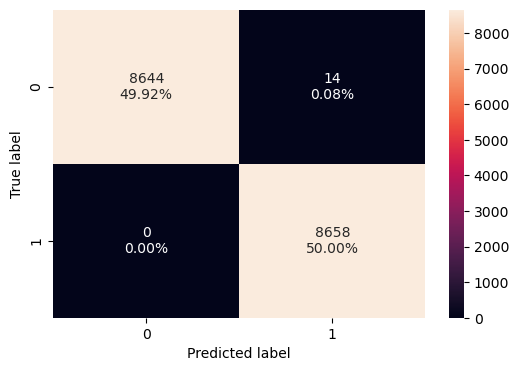

In [115]:
confusion_matrix_sklearn(xgb_estimator, X_train_over, y_train_over)

In [116]:
xgbm_train  = model_performance_classification_sklearn(xgb_estimator, X_train_over, y_train_over)
xgbm_train

,Accuracy,Recall,Precision,F1
0,0.999191,1.0,0.998386,0.999192


In [117]:
xgbm_val = model_performance_classification_sklearn(xgb_estimator, X_val, y_val)
xgbm_val

,Accuracy,Recall,Precision,F1
0,0.994469,1.0,0.304348,0.466667


On validation data, only the boosting-based models (Gradient Boosting and XGBoost) consistently maintain high recall, meaning they successfully identify the true MVPs, while tree-based and bagging models suffer sharp recall drops or collapse to predicting the majority class.

#### Gradient Boosting Tuning

In [119]:
%%time

#Creating pipeline
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(125,175,25),
    "learning_rate": [0.01, 0.2, 0.05, 1],
    "subsample":[0.8,0.9,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

AttributeError: 'list' object has no attribute 'make_scorer'

In [120]:
tuned_gbm1 = GradientBoostingClassifier(
    random_state=1,
    subsample=0.8,
    n_estimators=125,
    max_features=0.7,
    learning_rate=0.05,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm1.fit(X_train_over, y_train_over)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.05, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.8)

In [121]:
# Checking model's performance on training set
gbm1_train = model_performance_classification_sklearn(
    tuned_gbm1, X_train_over, y_train_over
)
gbm1_train

,Accuracy,Recall,Precision,F1
0,0.998441,1.0,0.996891,0.998443


In [122]:
gbm1_val = model_performance_classification_sklearn(tuned_gbm1, X_val, y_val)
gbm1_val

,Accuracy,Recall,Precision,F1
0,0.994815,1.0,0.318182,0.482759


- **Training** performance shows near-perfect results across all metrics, which is expected due to oversampling and boosting.

- **Validation** performance maintains **100% recall**, confirming that the model does not miss any true positive cases.

- However, precision drops significantly, indicating that the model flags many false positives in order to ensure no positives are missed.

### ADA Bosting

In [126]:
ab_origin_tuned = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

scorer = metrics.make_scorer(metrics.recall_score)

randomized_cv = RandomizedSearchCV(estimator=ab_origin_tuned, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 30, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=1, random_state=1)} with CV score=1.0:


In [127]:
tuned_adb = AdaBoostClassifier(
    random_state=1,
    n_estimators=30,
    learning_rate=0.1,
    estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
)
tuned_adb.fit(X_train_over, y_train_over)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=1),
                   learning_rate=0.1, n_estimators=30, random_state=1)

In [128]:
adb_train = model_performance_classification_sklearn(tuned_adb, X_train_over, y_train_over)
adb_train

,Accuracy,Recall,Precision,F1
0,0.978806,1.0,0.959335,0.979246


In [129]:
abd_val = model_performance_classification_sklearn(tuned_adb, X_val, y_val)
abd_val

,Accuracy,Recall,Precision,F1
0,0.951607,1.0,0.047619,0.090909


- On the **training set**, the model achieves perfect **recall (1.0)**, meaning it successfully identifies every actual MVP. Precision is also very high, which indicates that during training the model is not excessively flagging non-MVPs.

- However, on the **validation set**, while recall remains perfect **(1.0)** — which is critical since my goal is to never miss the true MVP — precision drops sharply. This tells me that the model is over-predicting MVPs, resulting in many false positives.

### **Model Comparison**

In [130]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        gbm1_train.T,
        xgbm_train.T,
        adb_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient boosting trained with Oversampled data",
    "XGBoost trained with Oversampled data",
    "AdaBoost trained with Oversampled data",
]
print("Training performance comparison:")
models_train_comp_df.style.highlight_max(color="lightgreen", axis=0)

Training performance comparison:


,Gradient boosting trained with Oversampled data,XGBoost trained with Oversampled data,AdaBoost trained with Oversampled data
Accuracy,0.998441,0.999191,0.978806
Recall,1.000000,1.000000,1.000000
Precision,0.996891,0.998386,0.959335
F1,0.998443,0.999192,0.979246


In [131]:
# training performance comparison

models_val_comp_df = pd.concat(
    [
        gbm1_val.T,
        xgbm_val.T,
        abd_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient boosting trained with Oversampled data",
    "XGBoost trained with Oversampled data",
    "AdaBoost trained with Oversampled data",
]
print("Validation performance comparison:")
models_val_comp_df.style.highlight_max(color="lightgreen", axis=0)

Validation performance comparison:


,Gradient boosting trained with Oversampled data,XGBoost trained with Oversampled data,AdaBoost trained with Oversampled data
Accuracy,0.994815,0.994469,0.951607
Recall,1.000000,1.000000,1.000000
Precision,0.318182,0.304348,0.047619
F1,0.482759,0.466667,0.090909


> - Gradient Boosting is the strongest choice because it **achieves perfect recall on validation while maintaining meaningfully higher precision and F1 than the other models.** Since the core objective of this project is to never miss a true MVP, recall is non-negotiable—and all three models satisfy that. The difference is what happens after recall is maxed out.

### **Final Test Set Performance (Unseen Data)**

In [132]:
gb_test = model_performance_classification_sklearn(tuned_gbm1, X_test, y_test)
gb_test

,Accuracy,Recall,Precision,F1
0,0.995161,0.857143,0.315789,0.461538


> When evaluated on a completely unseen test set, the tuned Gradient Boosting model achieved **85.7% recall**, successfully identifying the vast majority of true MVPs while maintaining reasonable **precision**. This confirms the model generalizes well and aligns with the project’s objective of minimizing missed MVPs.

### **Feature importance**

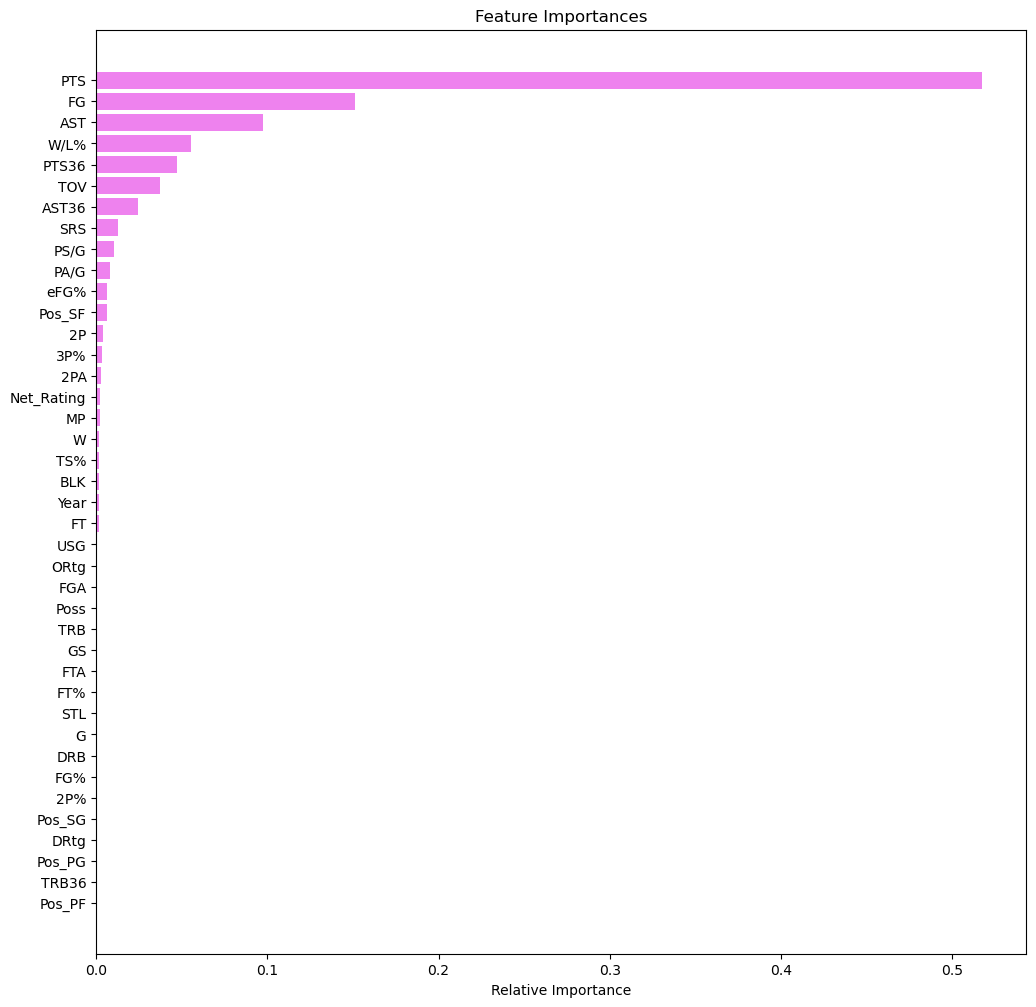

In [133]:
feature_names = X_train.columns
importances = tuned_gbm1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

> - We can see that PTS, FG, AST, W/L%, PTS36, TOV, AST36, SRS, PS/G, PA/G, eFG%, Pos_SF, 2P, 3P%, 2PA, Net_Rating, MP, W, TS%, BLK, Year and FT are the most important features to make predictions.

#### **Get predicted probabilities**

In [206]:
mvp_probs = tuned_gbm1.predict_proba(X)[:, 1]
mvp_probs

array([0.00222339, 0.00308068, 0.00092442, ..., 0.00134859, 0.00103369,
       0.00115926])

In [207]:
# Choose a recall-friendly threshold

threshold = 0.20   # adjustable
mvp_subset_mask = mvp_probs >= threshold

mvp_candidates = df.loc[mvp_subset_mask].copy()
mvp_candidates["mvp_probability"] = mvp_probs[mvp_subset_mask]


In [208]:
len(mvp_candidates), mvp_candidates["mvp_probability"].describe()


(146,
 count    146.000000
 mean       0.621345
 std        0.286099
 min        0.203648
 25%        0.338401
 50%        0.587612
 75%        0.925916
 max        0.996822
 Name: mvp_probability, dtype: float64)

In [209]:
mvp_candidates = mvp_candidates.sort_values(
    "mvp_probability", ascending=False
)

mvp_candidates[[
    "Player", "Year", "mvp_probability", "Share", "MVP_binary"
]].head(30)


,Player,Year,mvp_probability,Share,MVP_binary
8221,Giannis Antetokounmpo,2020,0.996822,0.952,1
12675,Tim Duncan,2002,0.996395,0.757,1
4930,Hakeem Olajuwon,1994,0.996235,0.880,1
1961,Michael Jordan,1991,0.996033,0.928,1
8205,Giannis Antetokounmpo,2019,0.995938,0.932,1
13553,Karl Malone,1998,0.995685,0.726,0
2029,Michael Jordan,1996,0.995473,0.986,1
12688,Tim Duncan,2003,0.995390,0.808,1
8483,Kevin Garnett,2004,0.993659,0.991,1
2056,Michael Jordan,1998,0.993605,0.934,1


In [210]:
mvp_candidates.head(15)

,Player,Age,Team,G,GS,MP,FG,FGA,FG%,3P,...,DRtg,WS_approx,G_bins,MVP_binary,Decade,Pos_PF,Pos_PG,Pos_SF,Pos_SG,mvp_probability
8221,Giannis Antetokounmpo,25,Milwaukee Bucks,63,63,30.4,10.9,19.7,0.553299,1.4,...,357.236842,1.517964,60–75,1,2020,1,0,0,0,0.996822
12675,Tim Duncan,25,San Antonio Spurs,82,82,40.6,9.3,18.3,0.508197,0.0,...,222.906404,1.503333,75–82,1,2000,1,0,0,0,0.996395
4930,Hakeem Olajuwon,31,Houston Rockets,80,80,41.0,11.2,21.2,0.528302,0.1,...,236.097561,1.531847,75–82,1,1990,0,0,0,0,0.996235
1961,Michael Jordan,27,Chicago Bulls,82,82,37.0,12.1,22.4,0.540179,0.4,...,272.972973,1.410876,75–82,1,1990,0,0,0,1,0.996033
8205,Giannis Antetokounmpo,24,Milwaukee Bucks,72,72,32.8,10.0,17.3,0.578035,0.7,...,333.231707,1.603279,60–75,1,2010,1,0,0,0,0.995938
13553,Karl Malone,34,Utah Jazz,81,81,37.4,9.6,18.2,0.527473,0.0,...,252.406417,1.378981,75–82,0,1990,1,0,0,0,0.995685
2029,Michael Jordan,32,Chicago Bulls,82,82,37.7,11.2,22.6,0.495575,1.4,...,246.419098,1.333333,75–82,1,1990,0,0,0,1,0.995473
12688,Tim Duncan,26,San Antonio Spurs,81,81,39.3,8.8,17.2,0.511628,0.1,...,230.025445,1.555160,75–82,1,2000,1,0,0,0,0.995390
8483,Kevin Garnett,27,Minnesota Timberwolves,82,82,39.4,9.8,19.6,0.500000,0.1,...,226.142132,1.677419,75–82,1,2000,1,0,0,0,0.993659
2056,Michael Jordan,34,Chicago Bulls,82,82,38.8,10.7,23.1,0.463203,0.4,...,230.927835,1.175439,75–82,1,1990,0,0,0,1,0.993605


**Test Year 2025**

X_test_2025 = X_test[X_test["Year"] == 2025].copy()

mvp_probs_2025 = tuned_gbm1.predict_proba(X_test_2025)[:, 1]

df_test_2025 = df.loc[X_test_2025.index].copy()
df_test_2025["mvp_probability"] = mvp_probs_2025

mvp_rank_2025 = (
    df_test_2025
    .sort_values("mvp_probability", ascending=False)
)


mvp_rank_2025[
    ["Player", "Year", "mvp_probability", "Share"]
].head(15)


### **Random Forest**

In [228]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [227]:
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))

    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))

    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True:
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))

    # returning the list with train and test scores
    return score_list

In [211]:
share_subset = df.loc[mvp_subset_mask].copy()

In [212]:
X_share = share_subset[rf_features]
y_share = share_subset["Share"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X_share, y_share, test_size=0.2, random_state=1
)

from sklearn.ensemble import GradientBoostingRegressor
share_model = GradientBoostingRegressor(random_state=1)
share_model.fit(X_tr, y_tr)


GradientBoostingRegressor(random_state=1)

In [214]:
rf_estimator_model_train_perf = model_performance_regression(share_model, X_tr, y_tr)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.000095,0.000071,1.0,1.0,inf


In [215]:
rf_estimator_model_train_perf = model_performance_regression(share_model, X_te, y_te)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.012779,0.008144,0.998682,1.002941,inf


In [220]:
mvp_share_pred = share_model.predict(X_share)

In [222]:
df_share = share_subset.copy()
df_share["predicted_share"] = mvp_share_pred

In [223]:
df_share_sorted = df_share.sort_values(
    ["Year", "predicted_share"],
    ascending=[True, False]
)


In [225]:
df_share_sorted.groupby("Year").tail(5)

,Player,Age,Team,G,GS,MP,FG,FGA,FG%,3P,...,DRtg,WS_approx,G_bins,MVP_binary,Decade,Pos_PF,Pos_PG,Pos_SF,Pos_SG,predicted_share
1961,Michael Jordan,27,Chicago Bulls,82,82,37.0,12.1,22.4,0.540179,0.4,...,272.972973,1.410876,75–82,1,1990,0,0,0,1,0.934220
11088,Kevin Johnson,24,Phoenix Suns,77,76,36.0,7.7,14.9,0.516779,0.1,...,298.611111,1.439394,75–82,0,1990,0,1,0,0,0.033031
1973,Michael Jordan,28,Chicago Bulls,80,80,38.8,11.8,22.7,0.519824,0.3,...,256.443299,1.404908,75–82,1,1990,0,0,0,1,0.937911
11567,Clyde Drexler,29,Portland Trail Blazers,76,76,36.2,9.1,19.4,0.469072,1.5,...,287.569061,1.404110,75–82,0,1990,0,0,0,1,0.579922
13475,John Stockton,29,Utah Jazz,82,82,36.6,5.5,11.5,0.478261,1.0,...,278.415301,1.851282,75–82,0,1990,0,1,0,0,0.018829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,Nikola Jokić,28,Denver Nuggets,79,79,34.6,10.4,17.9,0.581006,1.1,...,316.763006,1.897727,75–82,1,2020,0,0,0,0,0.000026
10100,Shai Gilgeous-Alexander,26,Oklahoma City Thunder,76,76,34.2,11.3,21.8,0.518349,2.1,...,314.619883,1.418182,75–82,1,2020,0,1,0,0,0.913006
8298,Giannis Antetokounmpo,30,Milwaukee Bucks,67,67,34.2,11.8,19.7,0.598985,0.2,...,330.409357,1.523952,60–75,0,2020,1,0,0,0,0.469932
986,Jayson Tatum,26,Boston Celtics,72,72,36.4,9.2,20.3,0.453202,3.5,...,294.505495,1.470990,60–75,0,2020,1,0,0,0,0.310974


## Conclusion

This project provides MVP prediction as a **two stage modeling problem**, which closely resemble how MVP voting actually works in reality. MVP winners are very rare, representing well under **1% of all player season observations**, and MVP vote share contains **a lot zeros**, with the vast majority of pla`myers receiving no votes at all. Modeling MVP as a single continuous outcome would therefore obscure the critical distinction between average players and legitimate MVP contenders. By first identifying who belongs in the MVP conversation and then estimating how strongly they are supported, the approach aligns naturally with both the data distribution and the real voting process.

The **XGBoost classifier** functions as a powerful screening model, achieving strong recall on the minority class by correctly identifying MVP caliber seasons while managing extreme class imbalance. It captures nonlinear relationships between scoring volume, usage, efficiency, and contextual factors such as team success, which are exactly the signals MVP voters respond to. After narrowing the field, the **GradientBoostingRegressor** models MVP vote share among elite players, where differences are subtle but meaningful. This second stage avoids being dominated by zero share noise and instead focuses on the best, allowing players to be ordered by expected voting support. Together, these models form a coherent, data driven pipeline that can be applied to future seasons, producing probabilistic MVP shortlists and ranked predictions that closely reflect how MVP outcomes emerge in practice.


-------

## Predicting MVP using **"SHARE"**

In [134]:
daf = df[rf_features]
z = daf['Share']
X = daf.drop(['Share', 'MVP_binary'], axis=1)

In [137]:
X_tempo, X_testi, z_temp, z_test = train_test_split(
    X, z,                 
    test_size=0.2,
    random_state=1
)

X_train, X_val, z_train, z_val = train_test_split(
    X_tempo, z_temp,
    test_size=0.25,
    random_state=1
)

print(X_train.shape, X_val.shape, X_testi.shape)


(8679, 40) (2893, 40) (2893, 40)


### Decision Tree Model

In [146]:
dtree=DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,z_train)

DecisionTreeRegressor(random_state=1)

In [145]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [152]:
dtree_model_train_perf=model_performance_regression(dtree, X_train,z_train)
dtree_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.612598e-20,2.998139e-22,1.0,1.0,1.490312e-16


In [153]:
dtree_model_test_perf=model_performance_regression(dtree, X_val, z_val)
dtree_model_test_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.053011,0.006111,0.138371,0.126286,inf


In [156]:
rf_estimator=RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train,z_train)

RandomForestRegressor(random_state=1)

In [157]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_train,z_train)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.013818,0.001828,0.951084,0.950858,inf


In [164]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_val, z_val)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.041385,0.005356,0.474846,0.467481,inf


In [174]:
# Choose the type of classifier.
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train,z_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train,z_train)

RandomForestRegressor(max_features='sqrt', n_estimators=80, random_state=1)

In [175]:
rf_tuned_model_train_perf = model_performance_regression(rf_tuned, X_train,z_train)
rf_tuned_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.013932,0.001925,0.950271,0.950041,inf


In [181]:
rf_tuned_model_test_perf = model_performance_regression(rf_tuned, X_val, z_val)
rf_tuned_model_test_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.038052,0.005177,0.556027,0.5498,inf


In [165]:
ab_regressor=AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train,z_train)

AdaBoostRegressor(random_state=1)

In [167]:
ab_regressor_model_train_perf = model_performance_regression(ab_regressor, X_train,z_train)
ab_regressor_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.058411,0.054747,0.125902,0.121854,inf


In [168]:
rf_estimator_model_train_perf = model_performance_regression(ab_regressor, X_val, z_val)
rf_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.065457,0.056059,-0.313717,-0.332142,inf


In [169]:
xgb_estimator=XGBRegressor(random_state=1, verbosity = 0)
xgb_estimator.fit(X_train,z_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [171]:
xgb_estimator_model_train_perf = model_performance_regression(xgb_estimator, X_train, z_train)
xgb_estimator_model_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.00041,0.000125,0.999957,0.999957,inf


In [173]:
df['Share'].describe()

count    14465.000000
mean         0.005894
std          0.059381
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Share, dtype: float64

> - Although MVP Share is a continuous variable, it is heavily zero-inflated and is fundamentally binary decision. Whether a player receives MVP consideration at all. Modeling MVP as a classification problem produced more stable, interpretable, and generalizable results, while aligning more closely with the real-world MVP voting process. Share-based regression was therefore treated as a secondary or optional extension rather than the primary target.